University Of Aberdeen

Final Project by Aleksandra Nenkova

# Soybean Forecasting Pipeline


This notebook containes a full soybean forecasting pipeline in several ML and DL models

### Libraries

All necessary libraries imported by groups. If any erros with the code occur please check the Requirements Sections in the Maintainance manual or excute -pip install requirements.txt

In [2]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

# Tuning imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# Linear regression import
from sklearn.linear_model import LinearRegression, Lasso

# XGBoost imports
from xgboost import XGBRegressor, DMatrix, train


# LSTM imports
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

# Commented out as transformers code does not work.
# # Transformer Imports
# import torch
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Loss functions for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Data

The data used in this study is from the paper "A CNN-RNN Framework for Crop Yield Prediction", please head to the their official GitHub repository: https://github.com/saeedkhaki92/CNN-RNN-Yield-Prediction to get the the cvs file called 'soybean_data_soilgrid250_modified_states_9.csv'.

In [ ]:
# Loading the dataset into a pandas dataframe
full_soybean_df = pd.read_csv('datasets/soybean_data_soilgrid250_modified_states_9.csv')

#### Data Exploration

In [ ]:
# General format of the dataset, more infromation on what each feature name stands for can be found at https://github.com/saeedkhaki92/CNN-RNN-Yield-Prediction
full_soybean_df.head(10)

loc_ID  year  yield     W_1_1     W_1_2     W_1_3     W_1_4     W_1_5  \
0       0  1980   32.5  0.274725  0.000000  1.615385  0.395604  0.967033   
1       0  1981   36.0  0.604396  0.000000  0.043956  0.000000  0.857143   
2       0  1982   37.0  2.098901  0.384615  1.681319  0.527473  6.340659   
3       0  1983   23.0  0.000000  0.000000  0.000000  1.032967  4.373626   
4       0  1984   28.5  0.000000  0.043956  0.197802  0.461538  0.142857   
5       0  1985   39.0  3.351648  1.560440  1.208791  0.000000  1.956044   
6       0  1986   36.5  0.131868  0.000000  0.000000  0.142857  2.549451   
7       0  1987   37.0  0.098901  2.527473  3.274725  0.065934  0.000000   
8       0  1988   27.0  0.000000  0.000000  5.505495  0.000000  2.923077   
9       0  1989   29.0  0.978022  0.000000  0.142857  1.252747  1.428571   

      W_1_6     W_1_7  ...   P_5   P_6   P_7   P_8   P_9  P_10  P_11  P_12  \
0  0.736264  1.153846  ...  22.0  22.0   0.0  23.0   3.0   0.0   0.0   0.0   
1  1.824176  0.000000  ...   1.0  13.0  15.0  27.0  15.0  10.0   6.0   4.0   
2  1.593407  1.868132  ...  22.0  13.0   2.0   8.0   5.0   3.0   1.0   1.0   
3  0.351648  0.263736  ...  16.0  24.0  22.0  14.0  16.0   2.0   1.0   0.0   
4  0.670330  4.615385  ...  23.0  13.0  13.0  29.0  10.0   4.0   3.0   1.0   
5  2.824176  0.109890  ...  21.0  22.0  13.0   4.0   2.0   4.0   1.0   0.0   
6  2.098901  0.857143  ...  26.0  16.0  14.0   9.0   2.0   4.0   0.0   0.0   
7  0.384615  0.000000  ...  30.0  15.0   7.0   5.0   2.0   1.0   0.0   0.0   
8  1.637363  0.000000  ...  20.0   9.0   2.0   0.0   1.0   0.0   0.0   0.0   
9  0.747253  1.758242  ...  40.0  11.0   8.0  10.0   4.0   2.0   0.0   1.0   

   P_13  P_14  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0  
5   0.0   0.0  
6   0.0   0.0  
7   0.0   0.0  
8   0.0   0.0  
9   0.0   0.0  

[10 rows x 395 columns]

In [ ]:
# Utilize the describe() to better understand data
full_soybean_df.describe()

loc_ID          year         yield         W_1_1         W_1_2  \
count  25345.000000  25345.000000  25345.000000  25345.000000  25345.000000   
mean     446.024305   1998.275873     38.518524      1.222743      1.050139   
std      307.735011     10.985831     11.033546      2.273733      1.812747   
min        0.000000   1980.000000      2.900000      0.000000      0.000000   
25%      176.000000   1989.000000     31.000000      0.000000      0.000000   
50%      352.000000   1998.000000     38.500000      0.380952      0.371429   
75%      717.000000   2007.000000     46.000000      1.387755      1.321429   
max     1045.000000   2018.000000     82.300000     26.233766     24.000000   

              W_1_3         W_1_4         W_1_5         W_1_6         W_1_7  \
count  25345.000000  25345.000000  25345.000000  25345.000000  25345.000000   
mean       1.055340      0.962273      1.478921      1.065204      1.248638   
std        1.588695      1.581800      2.287057      1.531881      1.930032   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.042857      0.038961      0.000000   
50%        0.428571      0.380952      0.590476      0.492063      0.496599   
75%        1.376623      1.194805      1.880952      1.404762      1.690476   
max       17.000000     17.020408     23.450549     16.171429     29.632653   

       ...           P_5           P_6           P_7           P_8  \
count  ...  25345.000000  25345.000000  25345.000000  25345.000000   
mean   ...     18.469110     20.021723     13.683316     10.669166   
std    ...     11.183689     10.030178      8.242995      8.692607   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...     10.000000     12.000000      7.000000      4.000000   
50%    ...     18.000000     20.000000     13.000000      9.000000   
75%    ...     26.000000     26.000000     19.000000     15.000000   
max    ...     48.000000     58.000000     40.000000     55.000000   

                P_9          P_10          P_11          P_12          P_13  \
count  25345.000000  25345.000000  25345.000000  25345.000000  25345.000000   
mean       6.514981      4.093959      1.989897      0.433690      0.022687   
std        6.628885      5.691429      4.092867      1.793228      0.327479   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.947368      2.000000      0.000000      0.000000      0.000000   
75%       10.000000      6.000000      2.000000      0.000000      0.000000   
max       41.000000     40.000000     25.000000     20.000000      7.000000   

               P_14  
count  25345.000000  
mean       0.006707  
std        0.115631  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        2.000000  

[8 rows x 395 columns]

Text(0.5, 1.0, 'Vapor Pressure')

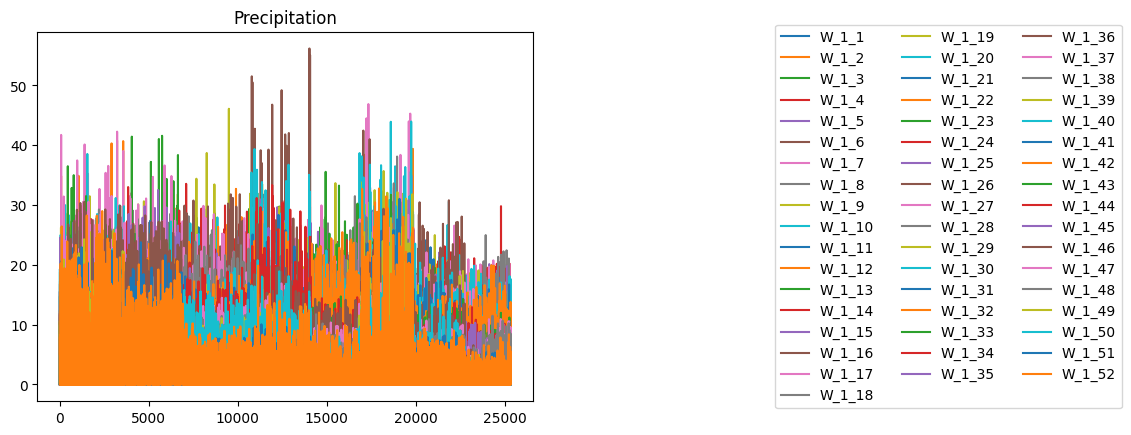

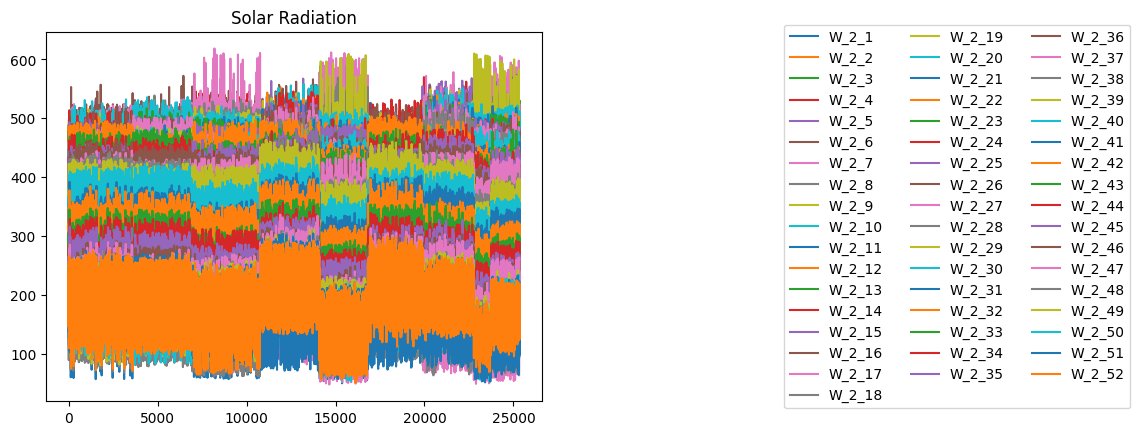

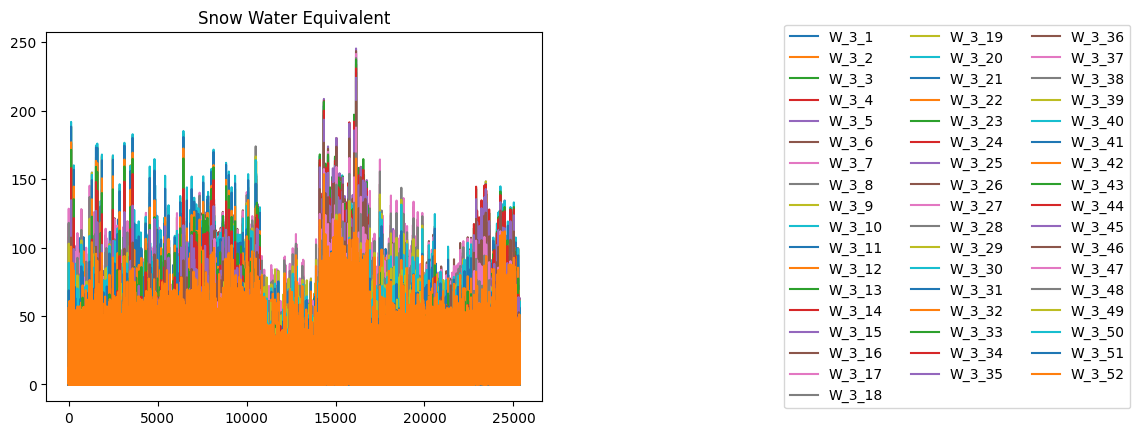

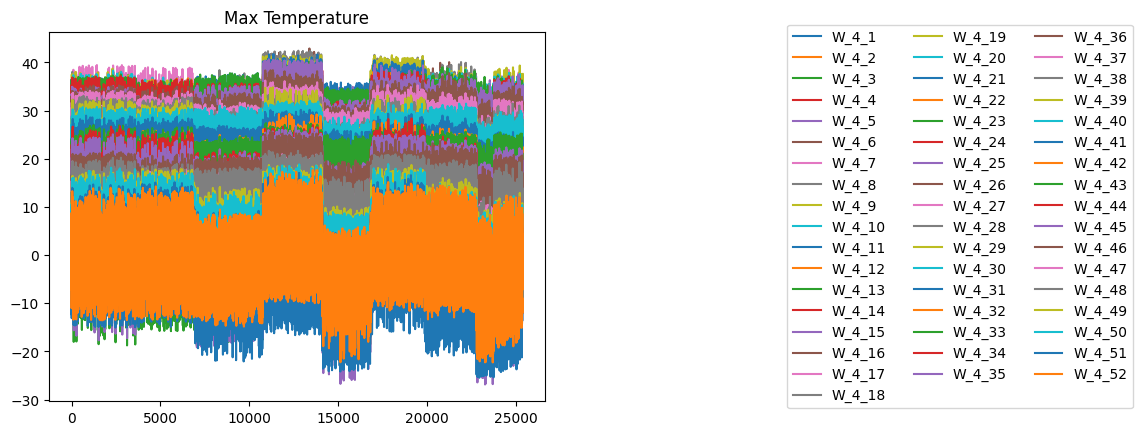

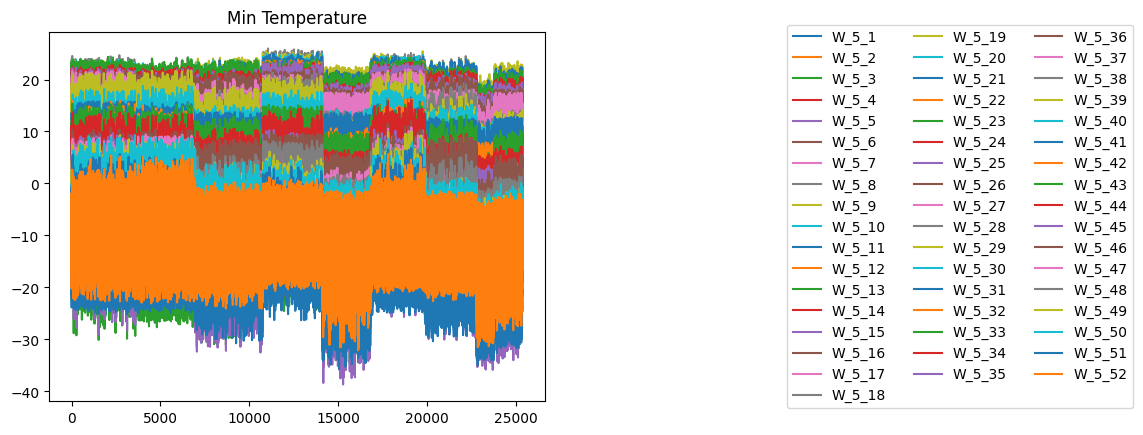

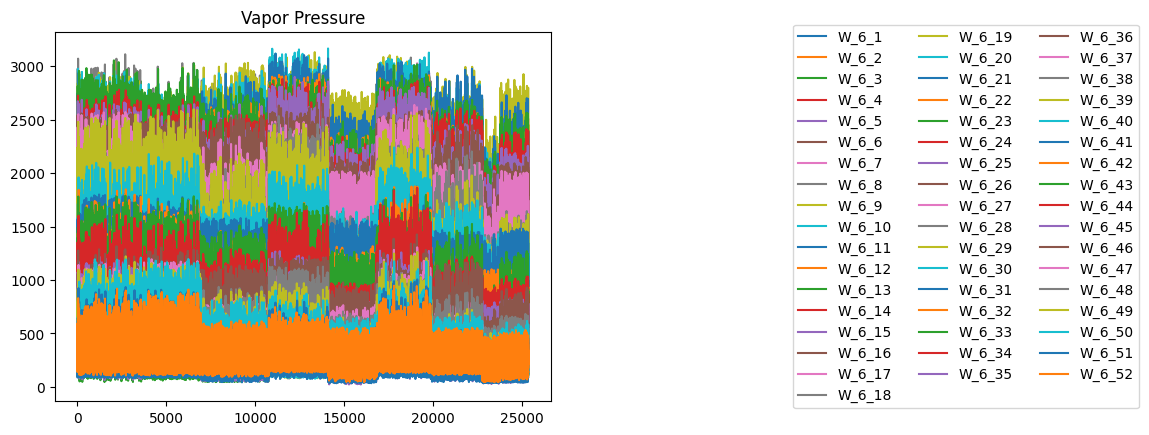

In [ ]:
# Generate graphs for data exploration, in thsi given example it's weather features

# W_1 = Percipitation
precipitation = full_soybean_df.filter(like='W_1').plot()
plt.legend(bbox_to_anchor=(2.2,0.5), loc="right", ncol = 3)
plt.title("Precipitation")

# W_2 = Solar_radiation
solar_radiation = full_soybean_df.filter(like='W_2').plot()
plt.legend(bbox_to_anchor=(2.2,0.5), loc="right", ncol = 3)
plt.title("Solar Radiation")

# W_3 = Snow water 
snow_water_equivalent = full_soybean_df.filter(like='W_3').plot()
plt.title("Snow Water Equivalent")
plt.legend(bbox_to_anchor=(2.2,0.5), loc="right", ncol = 3)

# W_4 = Max Temp
maximum_temperature = full_soybean_df.filter(like='W_4').plot()
plt.legend(bbox_to_anchor=(2.2,0.5), loc="right", ncol = 3)
plt.title("Max Temperature")

# W_5 = Min Temp
minimum_temperature = full_soybean_df.filter(like='W_5').plot()
plt.legend(bbox_to_anchor=(2.2,0.5), loc="right", ncol = 3)
plt.title("Min Temperature")

# W_6 =  Vapor 
vapor_pressure = full_soybean_df.filter(like='W_6').plot()
plt.legend(bbox_to_anchor=(2.2,0.5), loc="right", ncol = 3)
plt.title("Vapor Pressure")

#### State Dataframe Generation

In [ ]:
# Variables used to access each state

il = 'illinois'
iN = 'indiana'
ia = 'iowa'
ka = 'kansas'
mn = 'minnesota'
mo = 'missouri'
ne = 'nebraska'
nd = 'north dakota'
sd = 'south dakota'

In [ ]:
# List of the states used in Expriment 2
states = {il,iN,ia,ka,mn,mo,ne,nd,sd}
print(states)

{'nebraska', 'illinois', 'south dakota', 'north dakota', 'kansas', 'missouri', 'indiana', 'iowa', 'minnesota'}


##### State Dataframes Methods

Contains all methods necessary to do the state-related experiments

In [ ]:
# Method to create dictionary from the id_loc cvs
def csv_to_state_dict(file, state_dict= {}):
    with open(file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            state = row['State']
            county = row['County']
            id = row['ID_loc']
            if state not in state_dict:
                state_dict[state] = []
            state_dict[state].append((county, int(id)))
    return state_dict

# Method to get state only data from main dataset
def get_state_df(df, state_dict, states):
    id_list = [] 
    for state in states:
        id_list.extend([x[1] for x in state_dict[state]])
    state_df = df[df['loc_ID'].isin(id_list)]
    return state_df

def remove_state(df, dictionary, keys):
    values = []
    for key in keys:
        values.extend([x[1] for x in dictionary[key]])
    filtered_df = df[~df['loc_ID'].isin(values)]
    return filtered_df


In [ ]:
# State dictionary used following functions
state_dict = csv_to_state_dict('datasets/Soybeans_Loc_ID.csv')

In [ ]:
# the outlier states seperated into one dataframe
states_3 = get_state_df(full_soybean_df, state_dict, [ka, nd, sd])


In [ ]:
# variable for the non-outlier states
states_6 = remove_state(full_soybean_df, state_dict, [ka, nd, sd])


#### Data Preparation

The following cells hold the data_prep() method and the datasets used in the training and testing of the models

In [ ]:
scaler = MinMaxScaler() #used to normalize data

In [ ]:
# Data preparation method
def data_prep(df, val_set = False):

    # Defining the features and target variables
    X = df.drop(["yield",'loc_ID'], axis=1)
    y = df['yield']

    # Check if a validation set is needed
    if val_set == True:

        # Splits the X and y into sets by years
        X_train, y_train = X[df['year'] <= 2005].values, y[df['year'] <= 2005].values
        X_val, y_val = X[(df['year'] > 2005) & (df['year'] <= 2010)].values, y[(df['year'] > 2005) & (df['year'] <= 2010)].values
        X_test, y_test = X[df['year'] > 2010].values, y[df['year'] > 2010].values

        # Normalize the features 
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
        X_test = scaler.transform(X_test)

        # Reshape data for LSTM input
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
        X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

        return X_train, y_train, X_val, y_val, X_test, y_test

    else:
        #similar to code above but without the val set
        X_train, y_train = X[df['year'] <= 2010].values, y[df['year'] <= 2010].values
        X_test, y_test = X[df['year'] > 2010].values, y[df['year'] > 2010].values

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        return X_train, y_train, X_test, y_test

##### Data sets for benchmark models

Experiment 1: Full dataset forecasting

In [ ]:
# Used in linear, lasso regression and xgboost 
X_train, y_train, X_test, y_test = data_prep(full_soybean_df)

print("X_train shape: {}, y_train shape: {}\nX_test shape: {}, y_test shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape: (20918, 393), y_train shape: (20918,)
X_test shape: (4427, 393), y_test shape: (4427,)


In [ ]:
X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm = data_prep(full_soybean_df, True)
print("X_train_lstm shape: {}, y_train_lstm shape: {}\nX_val_lstm shape: {}, y_val_lstm shape: {}\nX_test_lstm shape: {}, y_test_lstm shape: {}"
.format(X_train_lstm.shape, y_train_lstm.shape, X_val_lstm.shape, y_val_lstm.shape, X_test_lstm.shape, y_test_lstm.shape))

X_train_lstm shape: (17734, 1, 393), y_train_lstm shape: (17734,)
X_val_lstm shape: (3184, 1, 393), y_val_lstm shape: (3184,)
X_test_lstm shape: (4427, 1, 393), y_test_lstm shape: (4427,)


Experiment 3: Non-outlier forecasting

In [ ]:
# 6 States
X_train_6, y_train_6, X_test_6, y_test_6 = data_prep(states_6)

print("X_train_6 shape: {}, y_train_6 shape: {}\nX_test_6 shape: {}, y_test shape_6: {}"
.format(X_train_6.shape, y_train_6.shape, X_test_6.shape, y_test_6.shape))

X_train_6 shape: (15900, 393), y_train_6 shape: (15900,)
X_test_6 shape: (3527, 393), y_test shape_6: (3527,)


In [ ]:
X_train_lstm_6, y_train_lstm_6, X_val_lstm_6, y_val_lstm_6, X_test_lstm_6, y_test_lstm_6 = data_prep(states_6, True)
print("X_train_lstm shape: {}, y_train_lstm shape: {}\nX_val_lstm shape: {}, y_val_lstm shape: {}\nX_test_lstm shape: {}, y_test_lstm shape: {}"
.format(X_train_lstm_6.shape, y_train_lstm_6.shape, X_val_lstm_6.shape, y_val_lstm_6.shape, X_test_lstm_6.shape, y_test_lstm_6.shape))

X_train_lstm shape: (13397, 1, 393), y_train_lstm shape: (13397,)
X_val_lstm shape: (2503, 1, 393), y_val_lstm shape: (2503,)
X_test_lstm shape: (3527, 1, 393), y_test_lstm shape: (3527,)


Experiment 5: Sorted dataset forecasting

In [ ]:
sorted_df = full_soybean_df.sort_values(by=['year', 'loc_ID'])

In [ ]:
X_train_s, y_train_s, X_test_s, y_test_s = data_prep(sorted_df)

print("X_train_s shape: {}, y_train_s shape: {}\nX_test_s shape: {}, y_test_s shape: {}".format(X_train_s.shape, y_train_s.shape, X_test_s.shape, y_test_s.shape))

X_train_s shape: (20918, 393), y_train_s shape: (20918,)
X_test_s shape: (4427, 393), y_test_s shape: (4427,)


In [ ]:
X_train_lstm_s, y_train_lstm_s, X_val_lstm_s, y_val_lstm_s, X_test_lstm_s, y_test_lstm_s = data_prep(sorted_df, True)
print("X_train_lstm_s shape: {}, y_train_lstm_s shape: {}\nX_val_lstm_s shape: {}, y_val_lstm_s shape: {}\nX_test_lstm_s shape: {}, y_test_lstm_s shape: {}".format(X_train_lstm.shape, y_train_lstm.shape, X_val_lstm.shape, y_val_lstm.shape, X_test_lstm.shape, y_test_lstm.shape))

X_train_lstm_s shape: (17734, 1, 393), y_train_lstm_s shape: (17734,)
X_val_lstm_s shape: (3184, 1, 393), y_val_lstm_s shape: (3184,)
X_test_lstm_s shape: (4427, 1, 393), y_test_lstm_s shape: (4427,)


### Results Auxilary Methods

The following sections contains all the additional methods needed for the experiments

#### Evaluation

In [ ]:
# Method for evaluating models
def evaluate(test, pred):
    mse = mean_squared_error(test, pred)
    rmse= mean_squared_error(test, pred, squared=False)
    mae = mean_absolute_error(test, pred)

    return mse, rmse, mae

def print_eval(mse, rmse, mae):
    print("MSE: ", mse)
    print("MSE Root: ", rmse)
    print("MAE: ", mae)

#### Vizualization

In [ ]:
# Vizualizes the prediction results in two different graphs
def viz_results(test, pred, ylim_zero=True):
    plt.figure()
    plt.xlabel('Entry')
    plt.ylabel('Yield')
    plt.plot(test, label='GroundTruth')
    plt.plot(pred, label='Prediction')
    plt.legend()
    
    if ylim_zero:
        plt.ylim(bottom=0)
    
    plt.show()

    plt.scatter(test, pred)
    plt.xlabel('True Value')
    plt.ylabel('Predictions')
    
    if ylim_zero:
        plt.xlim(left=0, right=max(test))
        plt.ylim(bottom=0)
        
    plt.show()

#### Methods to run models

The following two models are used to run a model with a specific dataset. The first method the bisc one to run all models, while the 2nd one allows you to run a model on one specified state.

In [1]:
def run_model(model, X_tr=X_train, y_tr= y_train, X_te = X_test, y_te = y_test, X_v = X_val_lstm, y_v = y_val_lstm, fit = True, viz = True):
    
    # If training is required fit model with the training data depending on the model
    if fit == True:
        if model == 'lstm':
            model, history = build_lstm_model(64, 100, X_tr, y_tr, X_v, y_v)
        
        else:
            model.fit(X_tr, y_tr)

    # Make predictions using the tesrting set    
    y_pred = model.predict(X_te)

    # Evaluate and print the results with the evaluate method
    mse, rmse, mae = evaluate(y_te, y_pred)
    print_eval(mse, rmse, mae)

    # Optional vizualization
    if viz == True:
        viz_results(y_te, y_pred)

    return model, mse, rmse, mae, y_pred, y_te

def pred_state(state, model, viz = True, val_set = False):
    state_df = get_state_df(full_soybean_df, state_dict, state)

    # If valiadation set is needed 
    if val_set == True:

        # Split the data 
        X_train, y_train, X_val, y_val, X_test, y_test = data_prep(state_df, True)

        _ , mse, rmse, mae, y_pred, y_test = run_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
        

    else:    
        X_train, y_train, X_test, y_test = data_prep(state_df)
        _, mse, rmse, mae, y_pred, y_test = run_model(model, X_train, y_train, X_test, y_test, viz=viz)
    

    return mse, rmse, mae, y_pred, y_test

NameError: name 'X_train' is not defined

### Linear Regression

#### Experiment 1: Full dataset forecasting

MSE:  99.69951264060742
MSE Root:  9.984964328459437
MAE:  7.746629688572898


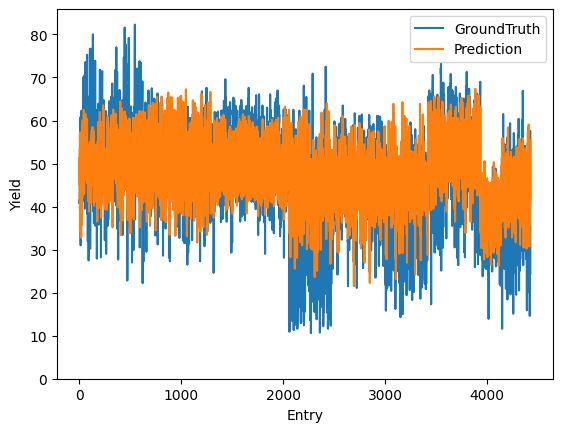

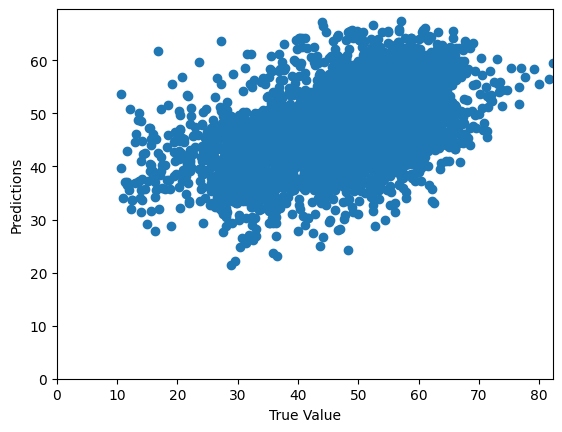

In [76]:
# Create model object 
reg = LinearRegression()

# Run the model save results
reg_fitted, mse_1_1, rmse_1_1, mae_1_1, y_pred_1_1, y_test_1_1 = run_model(reg)



#### Experiment 2: Per-state forecasting

____________________________________________________
State  illinois :
MSE :  228.813877520683
MSE Root:  15.126595040546402
MAE 12.207059664316427


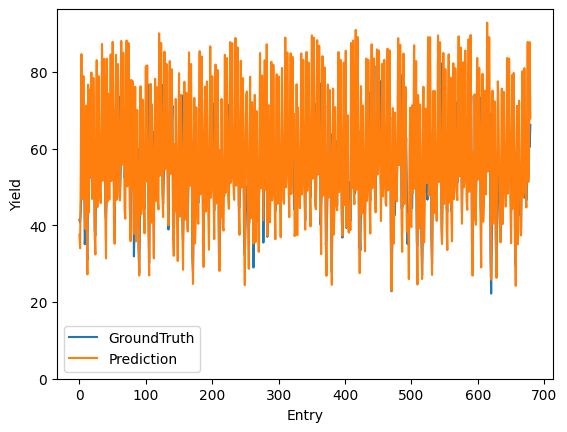

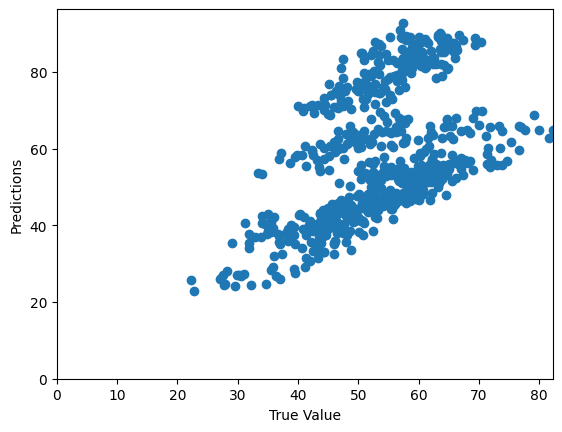

____________________________________________________
State  missouri :
MSE :  143.34647748732954
MSE Root:  11.972738930058132
MAE 9.97531665627583


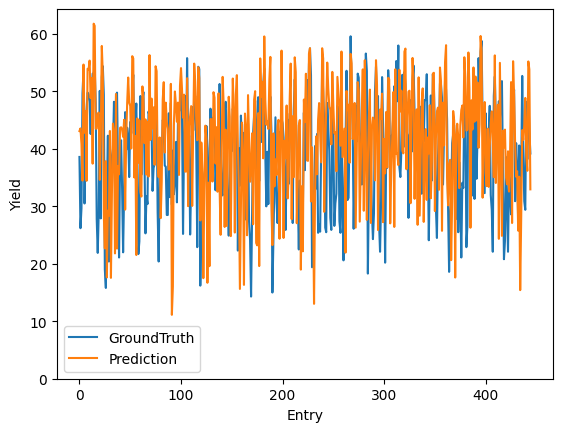

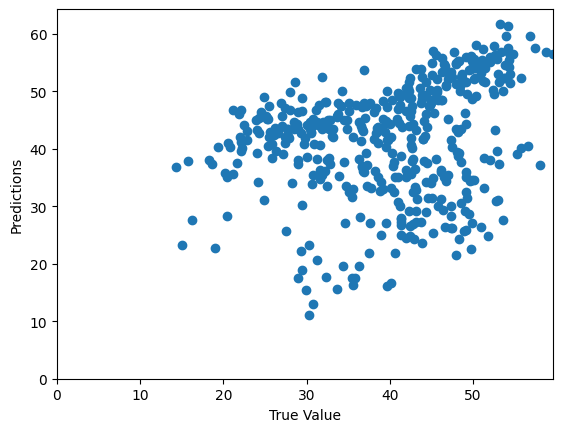

____________________________________________________
State  minnesota :
MSE :  97.8327698110466
MSE Root:  9.89104493019047
MAE 8.01574973699141


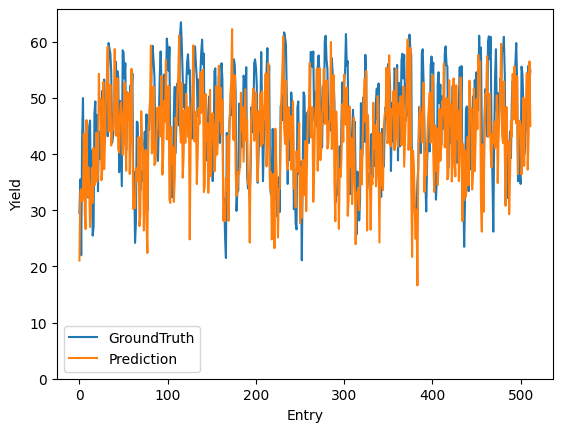

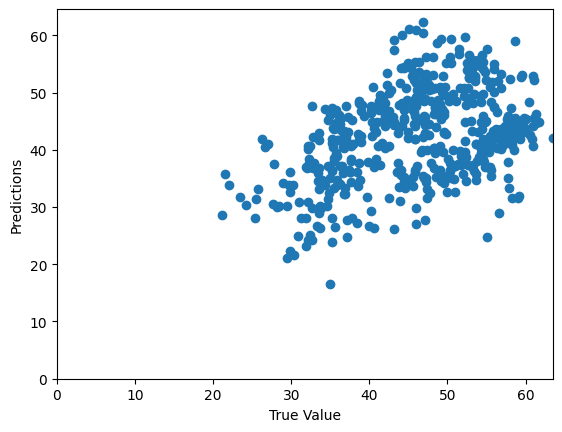

____________________________________________________
State  south dakota :
MSE :  108316.3303563109
MSE Root:  329.11446391234597
MAE 125.7918068259219


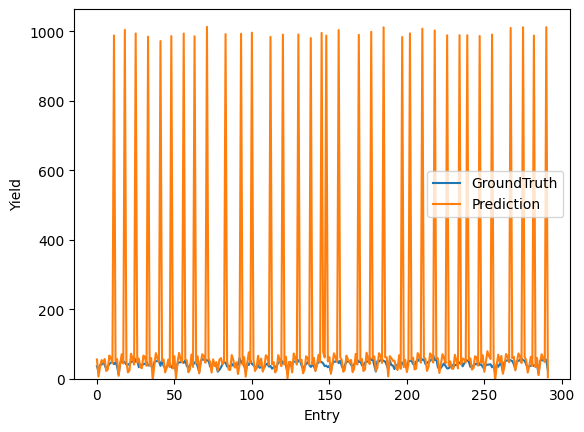

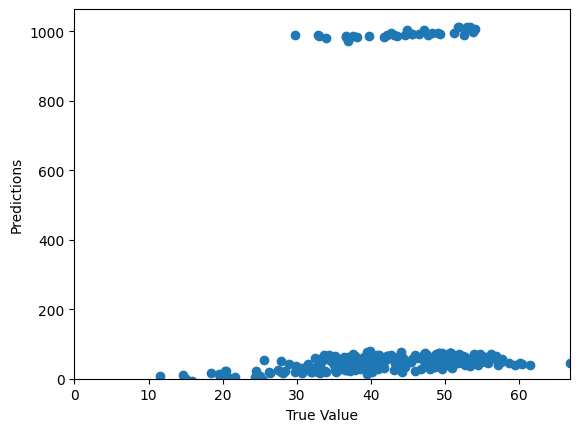

____________________________________________________
State  indiana :
MSE :  246.2963451951065
MSE Root:  15.693831437705278
MAE 13.505574414067892


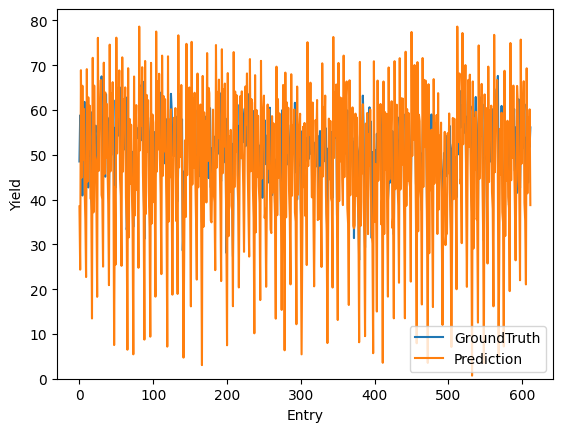

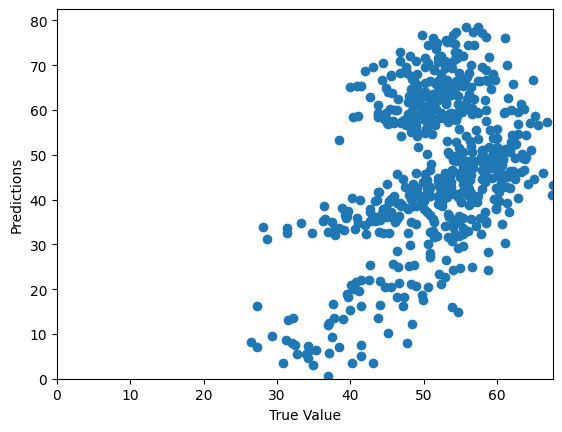

____________________________________________________
State  nebraska :
MSE :  348.23327865822864
MSE Root:  18.6610095830378
MAE 14.312519692426065


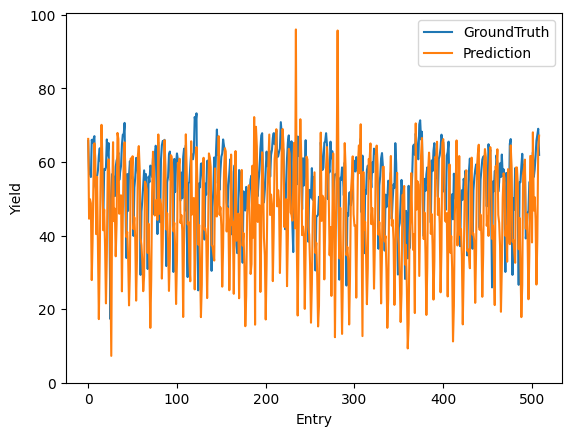

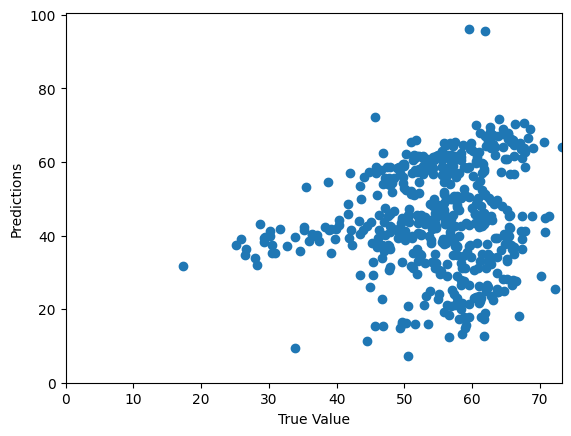

____________________________________________________
State  north dakota :
MSE :  58184.84277607732
MSE Root:  241.2153452334186
MAE 175.20350933118928


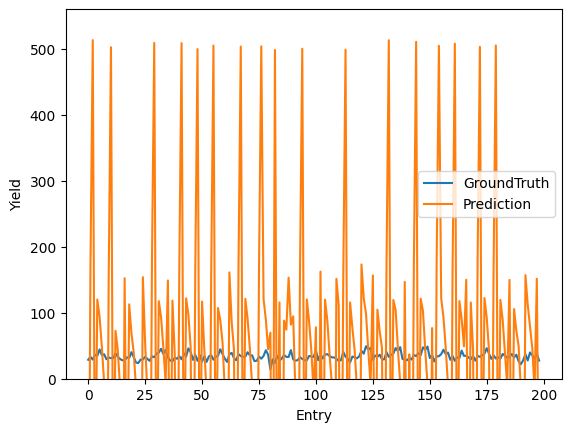

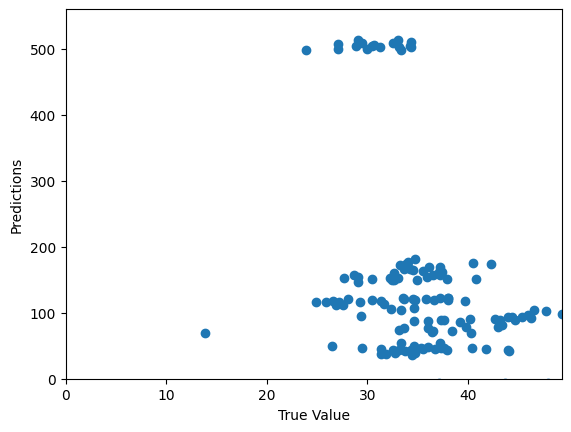

____________________________________________________
State  iowa :
MSE :  80.02661595533351
MSE Root:  8.945759663401063
MAE 7.619497731513839


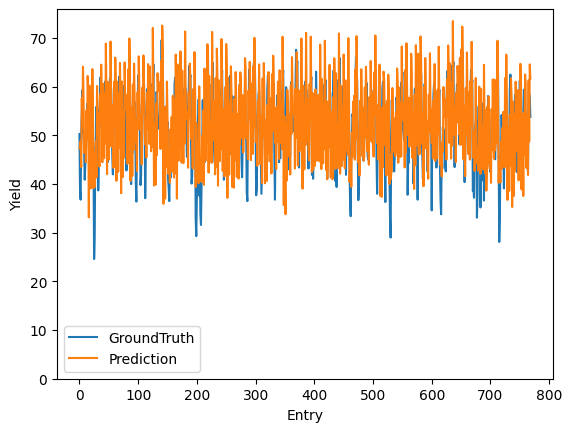

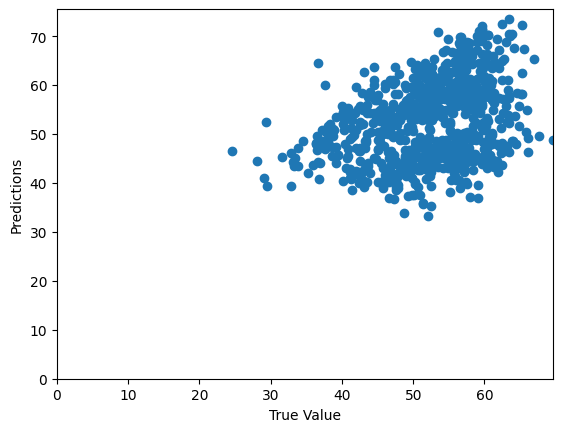

____________________________________________________
State  kansas :
MSE :  1.5032336087589698e+19
MSE Root:  3877155669.764847
MAE 191713019.82495323


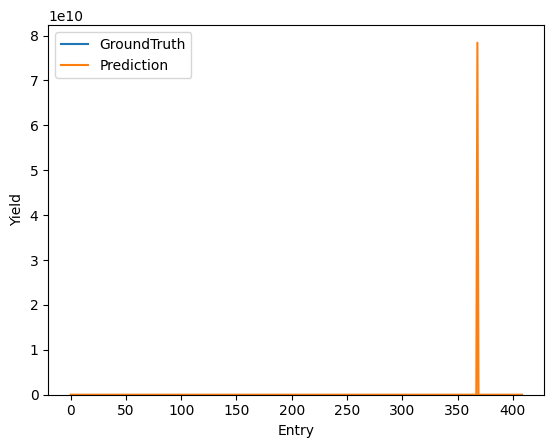

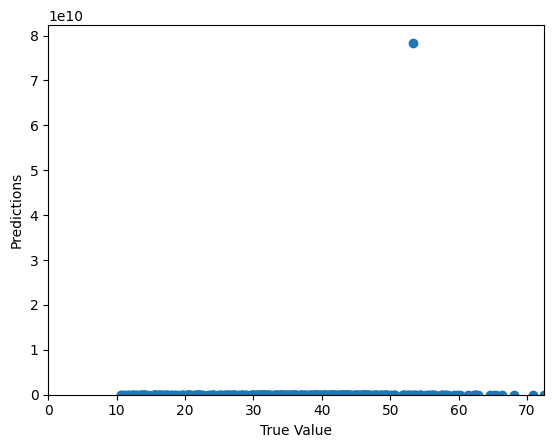

In [129]:
# Loop through the states list
for state in states:
    print("____________________________________________________")
    print("State ", state, ":")

    #Store results fro later
    mse_1_2, rmse_1_2, mae_1_2, y_pred_1_2, y_test_1_2 = pred_state(state, reg)
        

#### Experiment 3: Non-outlier dataset forecasting

MSE:  65.99281656880706
MSE Root:  8.123596282977575
MAE:  6.274851872649945


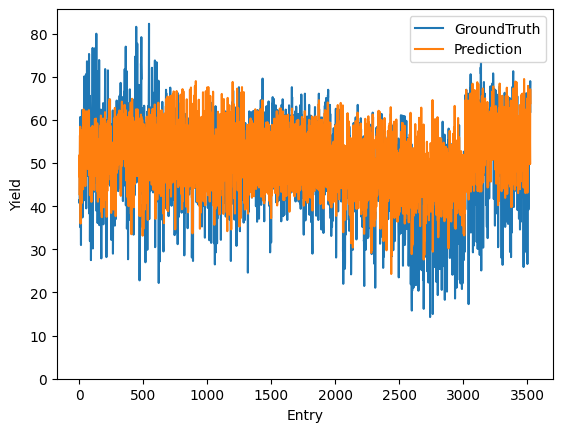

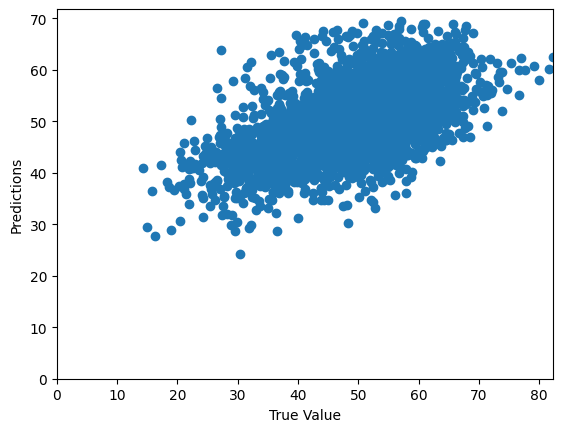

In [77]:
# Make predictions with best model

# Run the model save results
reg_fitted_state_6, mse_1_3, rmse_1_3, mae_1_3, y_pred_1_3, y_test_1_3 = run_model(reg, X_train_6, y_train_6, X_test_6, y_test_6)


#### Experiment 4: Predicting outlier yield with non-outlier-trained models

MSE :  798730.5241538318
MSE Root:  893.7172506748607
MAE 648.727392620681


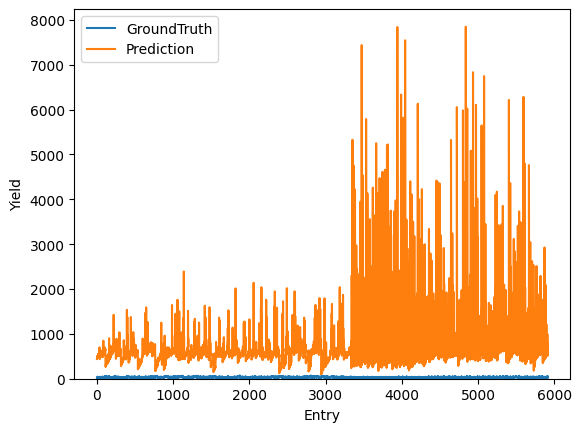

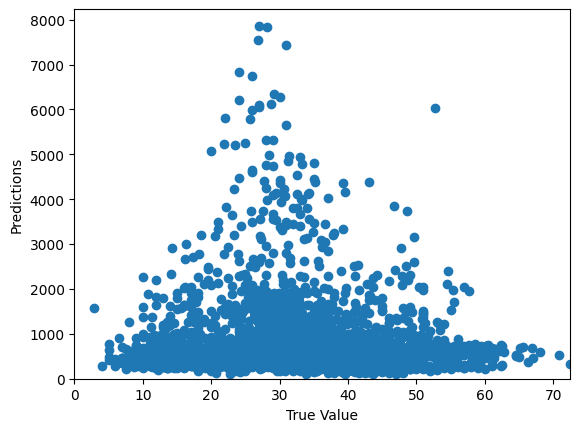

In [158]:
X_test_state_3 = states_3.drop(["yield",'loc_ID'], axis=1).values    
y_test_state_3 = states_3['yield'].values
X_test_state_3 = scaler.transform(X_test_state_3)
X_test_lstm_state_3 = np.reshape(X_test_state_3, (X_test_state_3.shape[0], 1, X_test_state_3.shape[1]))

_, mse_1_4, rmse_1_4, mae_1_4, y_pred_1_4, y_test_1_4 = run_model(reg_fitted_state_6, X_te = X_test_state_3, y_te = y_test_state_3, fit = False)



#### Experiment 5: Sorted data forecasting

MSE:  99.69951264061088
MSE Root:  9.98496432845961
MAE:  7.746629688573095


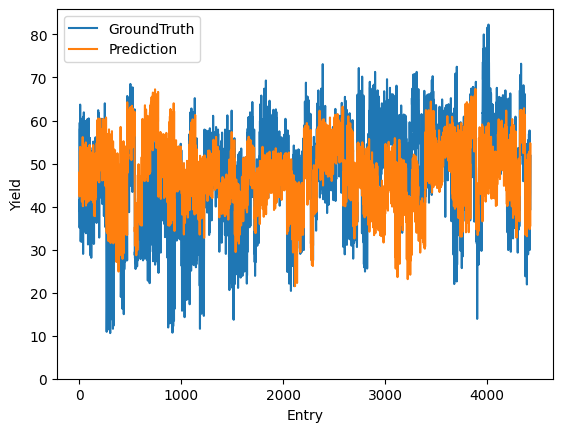

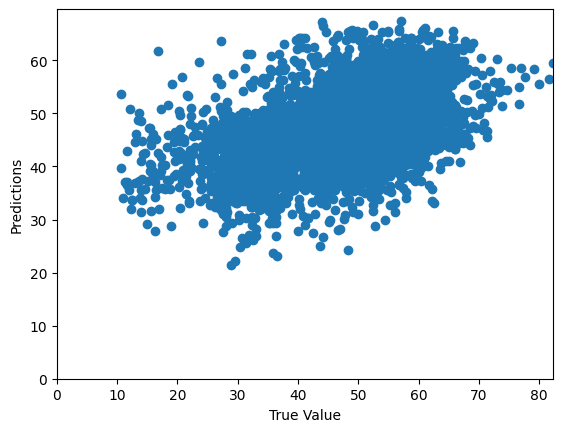

In [78]:
reg_fitted_s, mse_1_5, rmse_1_5, mae_1_5, y_pred_1_5, y_test_1_5 = run_model(reg,X_train_s, y_train_s, X_test_s, y_test_s)

### Lasso Regression

#### Experiment 1: Full dataset forecasting

##### Tuning

In [ ]:
# Define the hyperparameters to tune
params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
          'fit_intercept': [True, False],
          'positive': [True, False]}

# Create an instance of the Lasso regression model
lasso = Lasso()

# Create an instance of the GridSearchCV class
grid = GridSearchCV(lasso, params, cv=5)

# Fit the GridSearchCV object to the training data
grid.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid.best_params_)

c:\Users\Asus\Anaconda3\envs\dissertation\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+04, tolerance: 1.721e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Asus\Anaconda3\envs\dissertation\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.311e+03, tolerance: 1.686e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Asus\Anaconda3\envs\dissertation\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

##### Prediction

MSE:  82.04772889357697
MSE Root:  9.0580201420386
MAE:  6.95388747694987


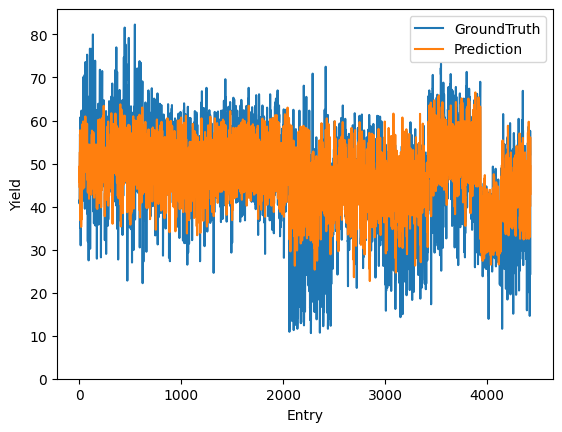

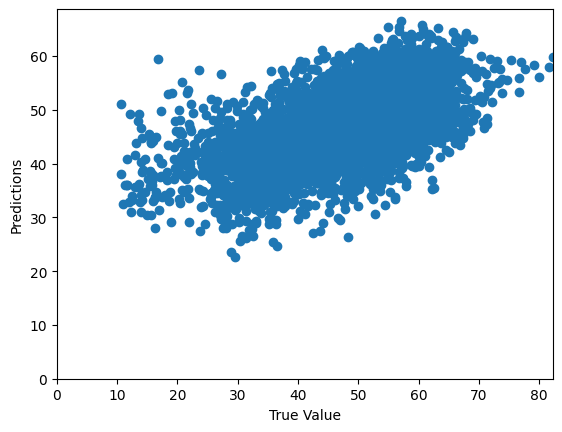

In [79]:
# Create model with best parameters
lasso = Lasso(alpha= 0.001, fit_intercept= True, positive= False, tol=1e-2)

# Run the model save results
lasso_fitted, mse_2_1, rmse_2_1, mae_2_1, y_pred_2_1, y_test_2_1 = run_model(lasso)

#### Experiment 2: Per-state forecasting

____________________________________________________
State  illinois :
MSE :  228.813877520683
MSE Root:  15.126595040546402
MAE 12.207059664316427


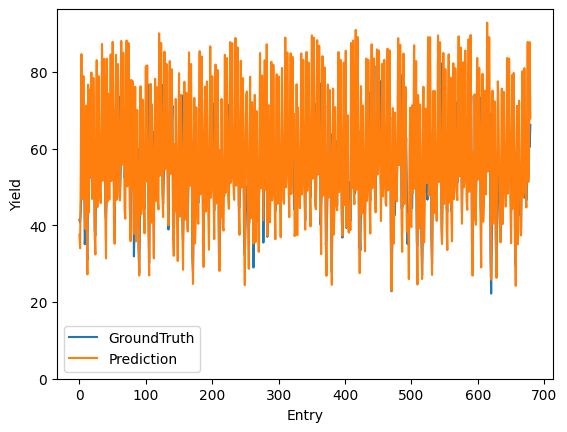

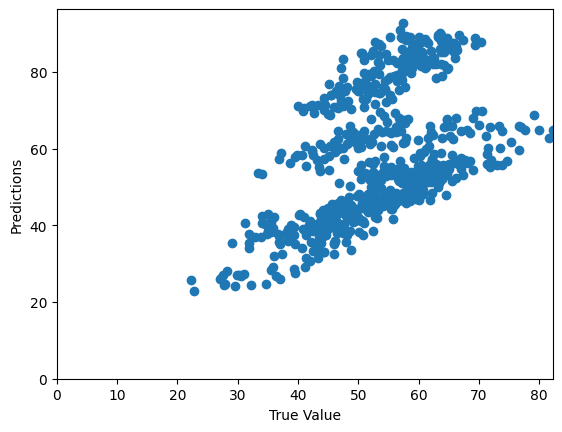

____________________________________________________
State  missouri :
MSE :  143.34647748732954
MSE Root:  11.972738930058132
MAE 9.97531665627583


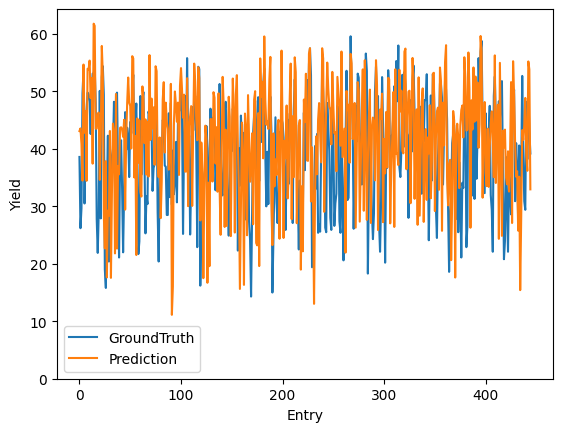

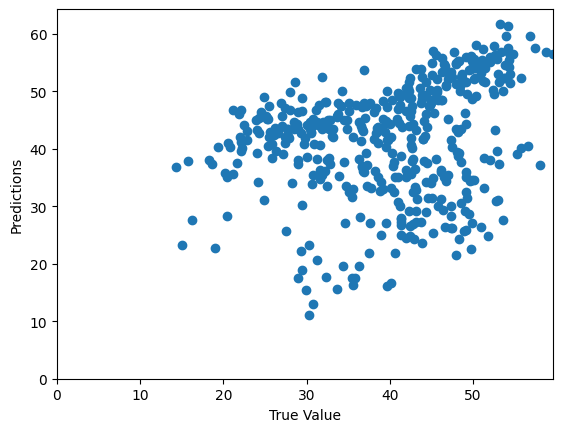

____________________________________________________
State  minnesota :
MSE :  97.8327698110466
MSE Root:  9.89104493019047
MAE 8.01574973699141


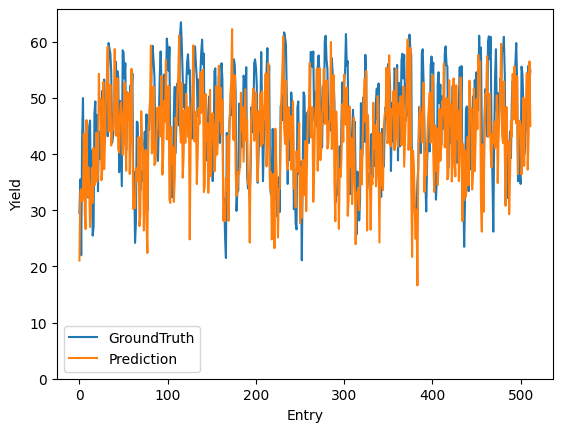

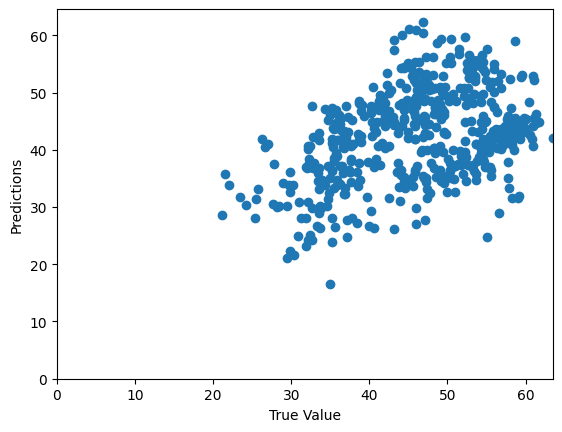

____________________________________________________
State  south dakota :
MSE :  108316.3303563109
MSE Root:  329.11446391234597
MAE 125.7918068259219


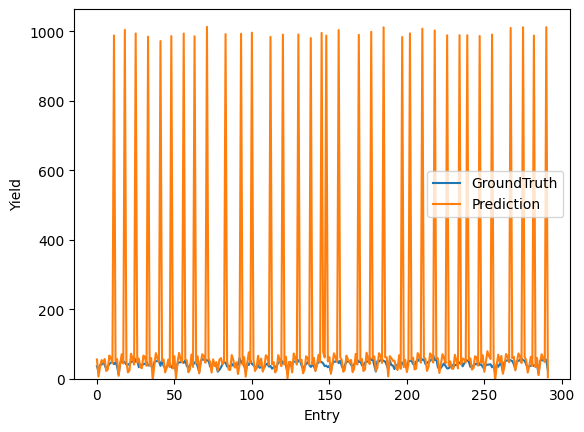

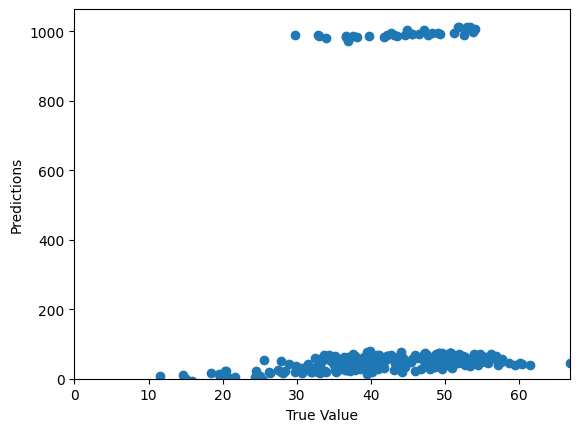

____________________________________________________
State  indiana :
MSE :  246.2963451951065
MSE Root:  15.693831437705278
MAE 13.505574414067892


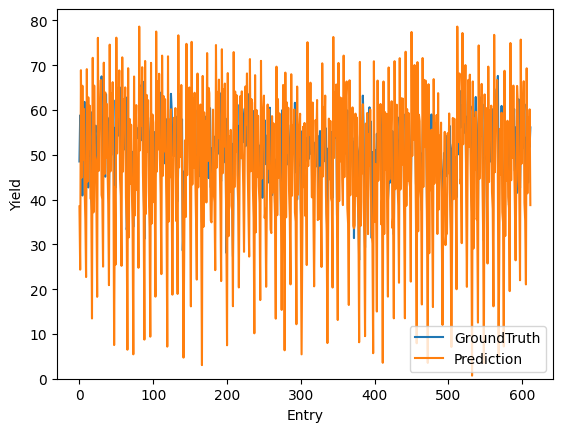

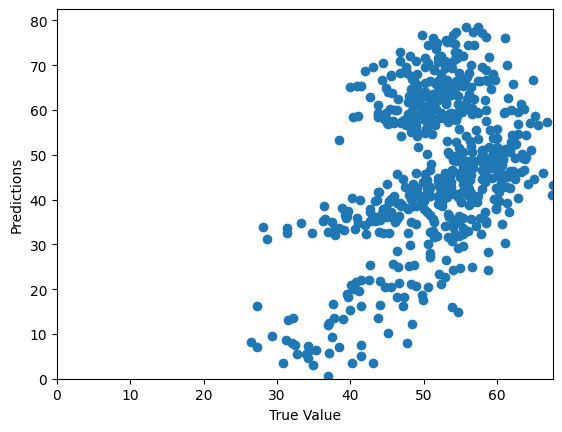

____________________________________________________
State  nebraska :
MSE :  348.23327865822864
MSE Root:  18.6610095830378
MAE 14.312519692426065


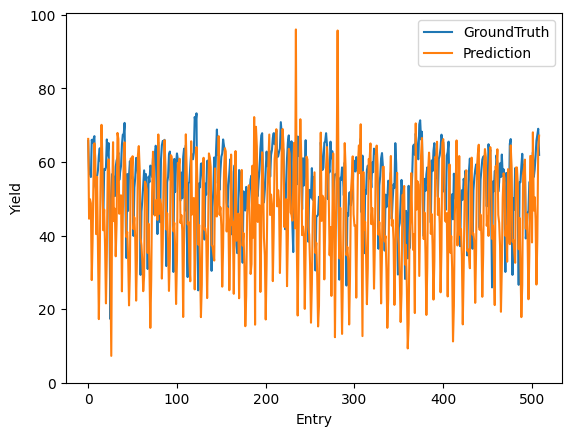

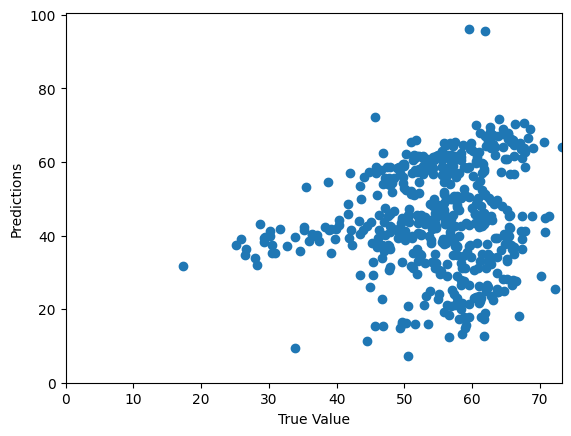

____________________________________________________
State  north dakota :
MSE :  58184.84277607732
MSE Root:  241.2153452334186
MAE 175.20350933118928


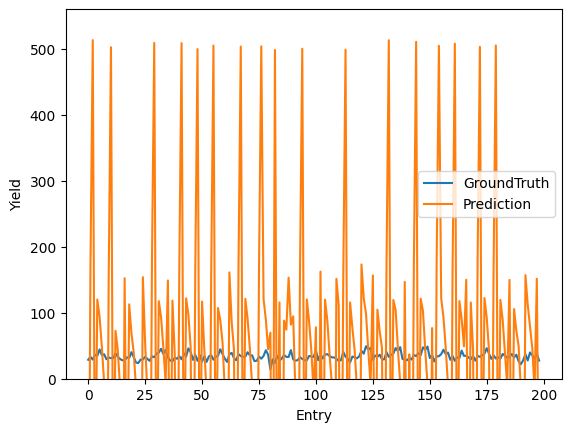

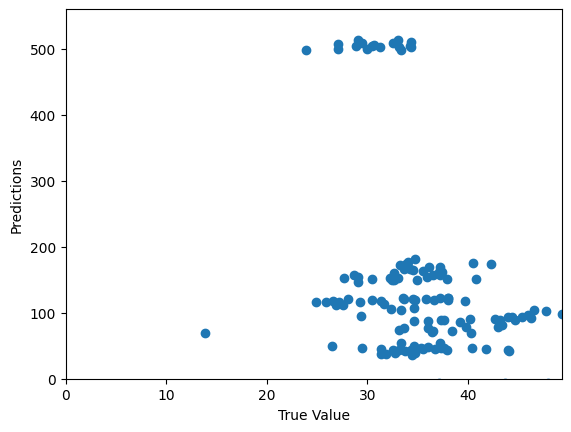

____________________________________________________
State  iowa :
MSE :  80.02661595533351
MSE Root:  8.945759663401063
MAE 7.619497731513839


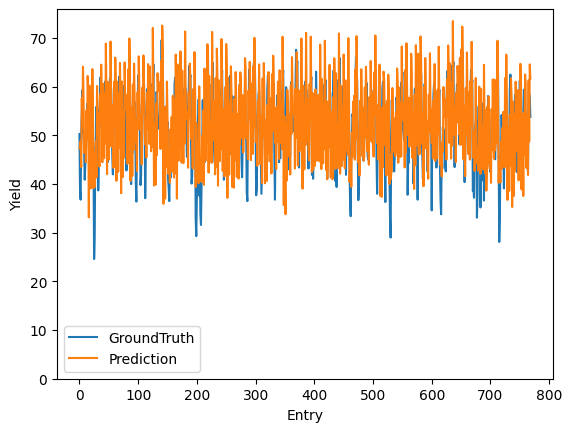

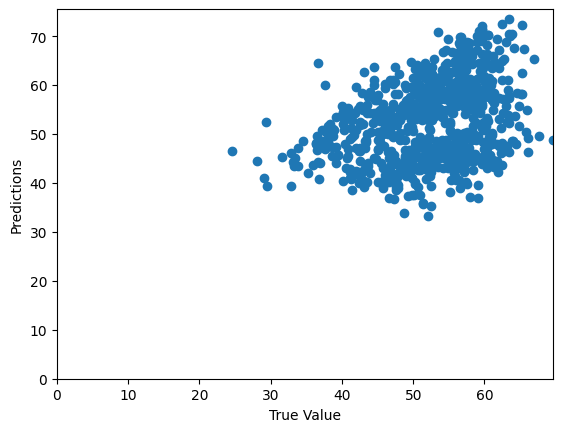

____________________________________________________
State  kansas :
MSE :  1.5032336087589698e+19
MSE Root:  3877155669.764847
MAE 191713019.82495323


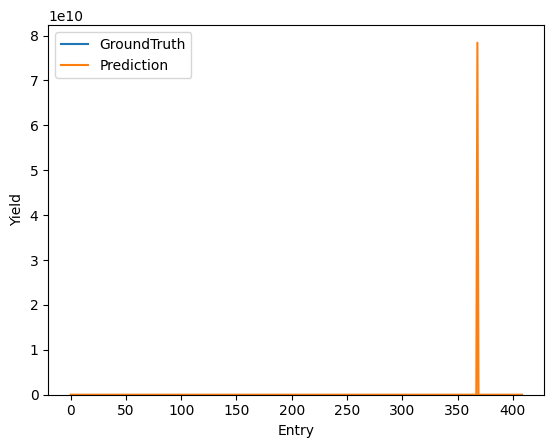

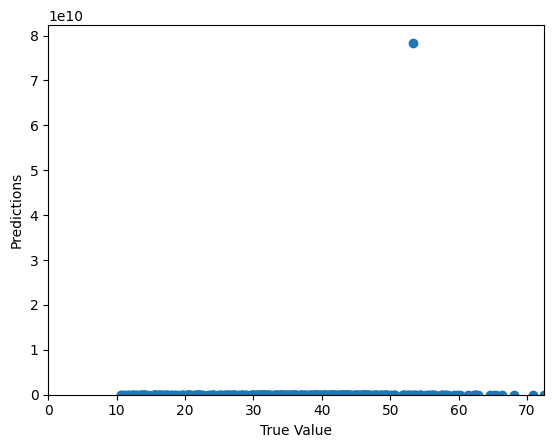

In [137]:
for state in states:
    print("____________________________________________________")
    print("State ", state, ":")

    #Store results fro later
    mse_2_2, rmse_2_2, mae_2_2, y_pred_state, y_test_state = pred_state(state, reg)

#### Experiment 3: Non-outlier dataset forecasting

MSE :  50.65033865633681
MSE Root:  7.116905131891025
MAE 5.467538831001041


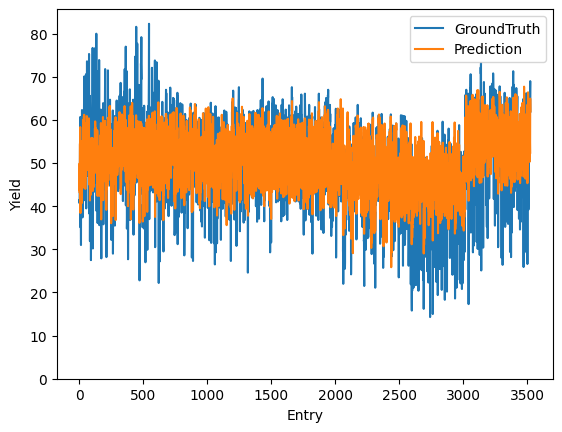

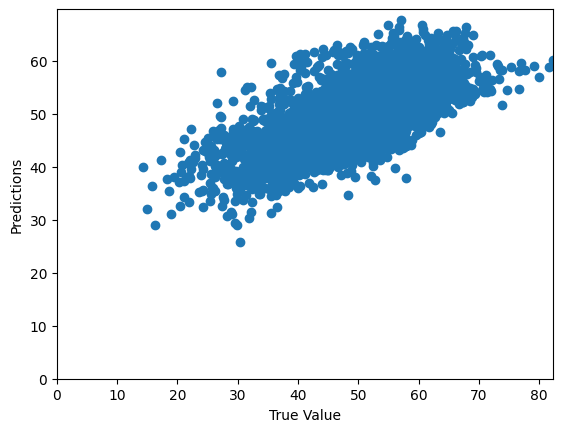

In [136]:
# Run the model save results
lasso_fitted_state_6, mse_2_3, rmse_2_3, mae_2_3, y_pred_2_3, y_test_2_3 = run_model(lasso, X_train_6, y_train_6, X_test_6, y_test_6)

#### Experiment 4: Predicting outlier yield with non-outlier-train models

MSE :  110365.71322765561
MSE Root:  332.21335498088513
MAE 81.25348616077932


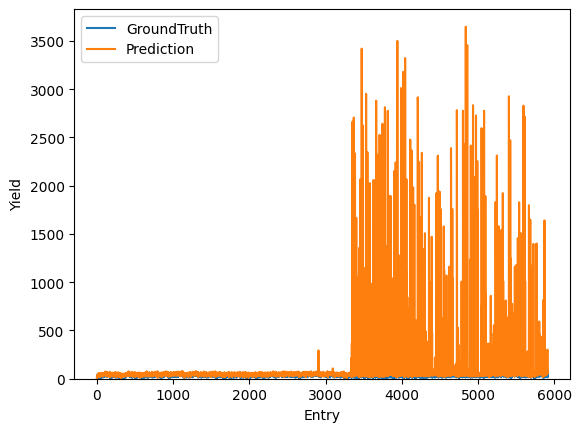

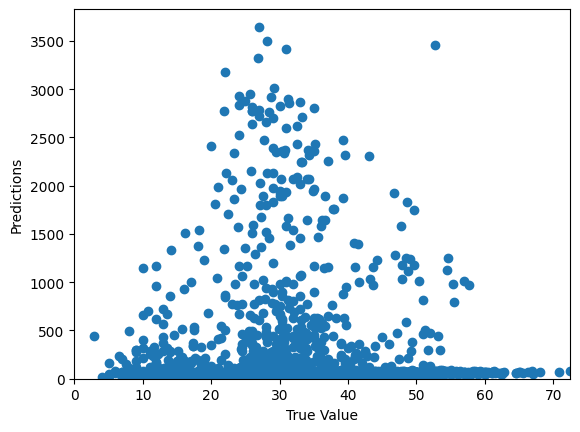

In [139]:
_, mse_2_4, rmse_2_4, mae_2_4, y_pred_2_4, y_test_2_4 = run_model(lasso_fitted_state_6, X_te = X_test_state_3, y_te = y_test_state_3, fit = False)

#### Experiment 5: Sorted data forecasting

MSE:  82.04772889357697
MSE Root:  9.0580201420386
MAE:  6.953887476949869


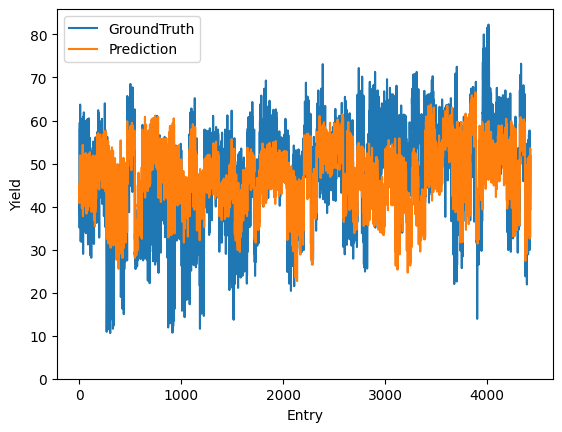

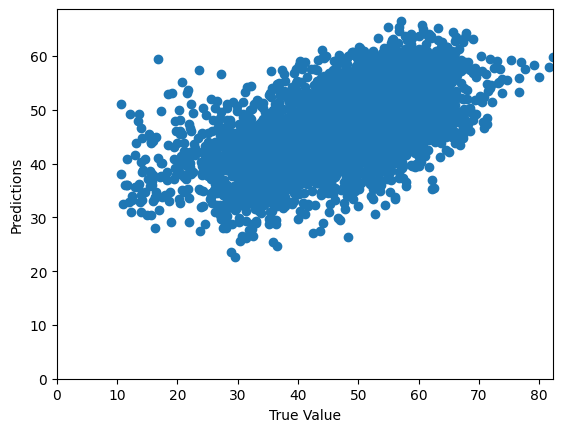

In [80]:
lasso_fitted_s, mse_2_5, rmse_2_5, mae_2_5, y_pred_2_5, y_test_2_5 = run_model(lasso,X_train_s, y_train_s, X_test_s, y_test_s)

### XGBoost

#### Experiment 1: Full dataset forecasting

##### Tuning

In [ ]:
# Define the parameter grid to search over
param_grid = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.1, 0.5],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5, 10],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "gamma": [0, 0.1, 0.5]
}

# Create an XGBoost Regressor object
xgb = XGBRegressor()

# Create a GridSearchCV object to search over the parameter grid
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, verbose=3)

# Fit the GridSearchCV object to the training data
grid.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters found:")
print(grid.best_params_)

# Use the best model to make predictions on the testing data
y_pred = grid.predict(X_test)

# Print the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5;, score=-1.662 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5;, score=-1.830 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5;, score=-1.721 total time=   0.6s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5;, score=-1.793 total time=   0.6s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5;, score=-1.579 total time=   0.6s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subs

##### Prediction

MSE :  98.94765224582477
MSE Root:  9.94724344961079
MAE 8.377366742620302


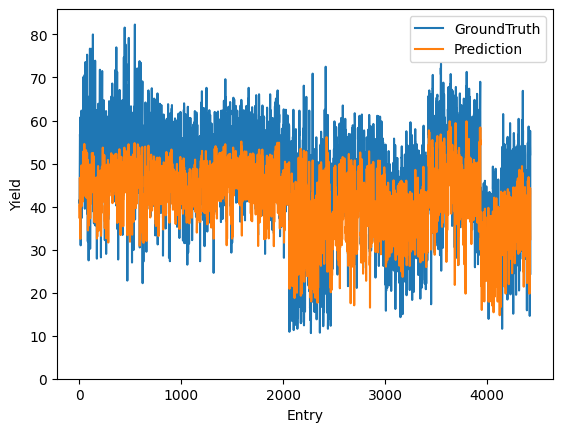

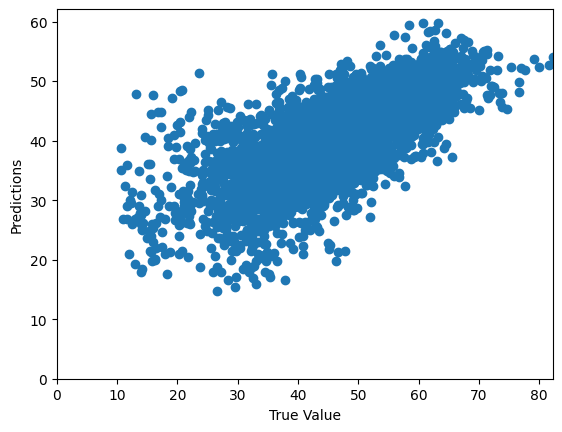

In [177]:
#Creating the XGBRegressor model
xgb = XGBRegressor( colsample_bytree=0.7, gamma=0.1, learning_rate = 0.01, 
                      max_depth = 7, min_child_weight = 5, n_estimators=1000,
                      subsample =  0.5 )

xgb1 = XGBRegressor()

# Run the model save results
xgb_fitted, mse_3_1, rmse_3_1, mae_3_1, y_pred_3_1, y_test_3_1 = run_model(xgb1)



#### Experiment 2: Per-state forecasting

____________________________________________________
State  illinois :
MSE :  133.77094671941876
MSE Root:  11.565939076418255
MAE 10.069262555066278


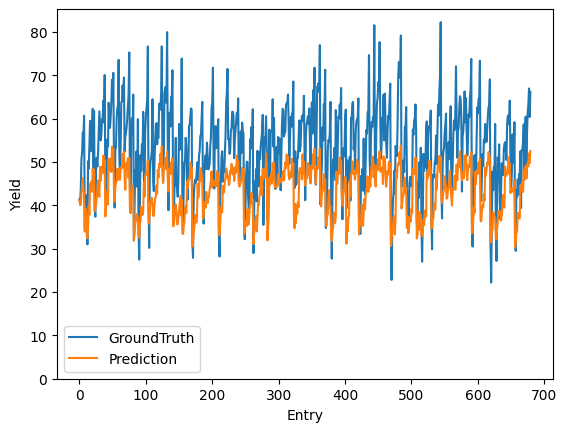

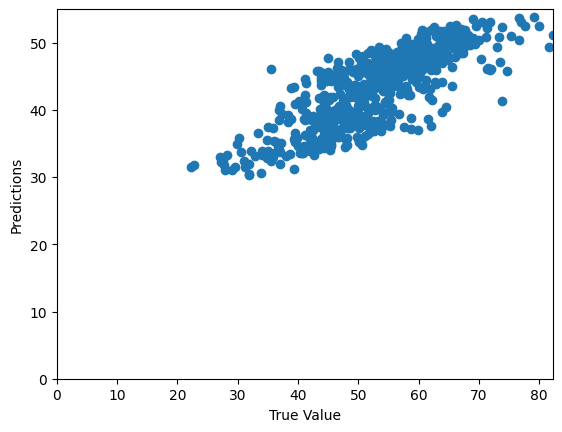

____________________________________________________
State  missouri :
MSE :  82.89639049666489
MSE Root:  9.104745493239495
MAE 7.778657220561853


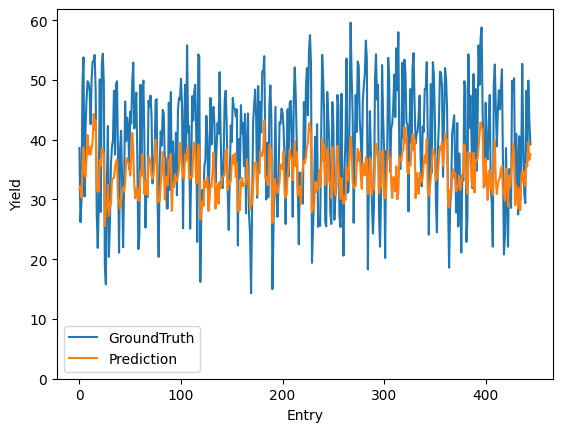

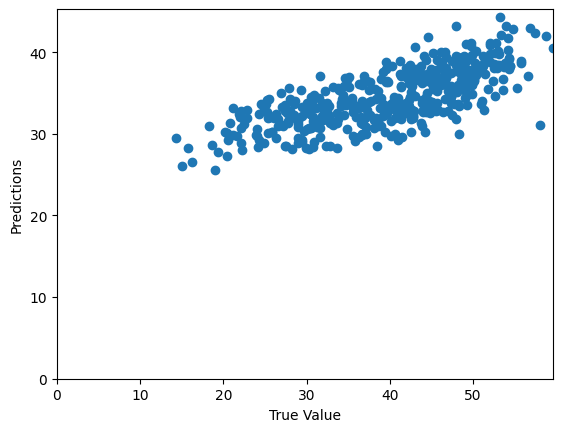

____________________________________________________
State  minnesota :
MSE :  101.00005214244084
MSE Root:  10.049878215303947
MAE 8.60381651967764


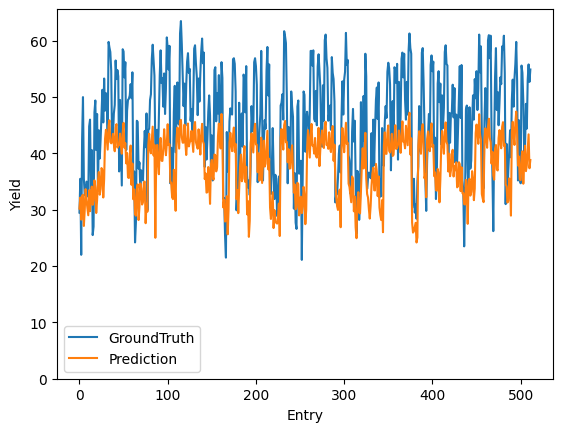

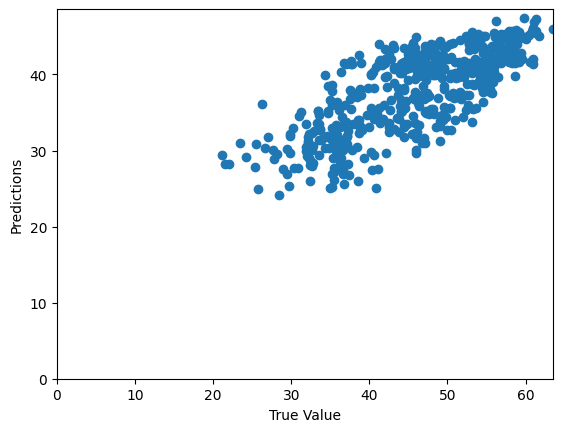

____________________________________________________
State  south dakota :
MSE :  117.93215715052796
MSE Root:  10.859657321965917
MAE 9.462251399314566


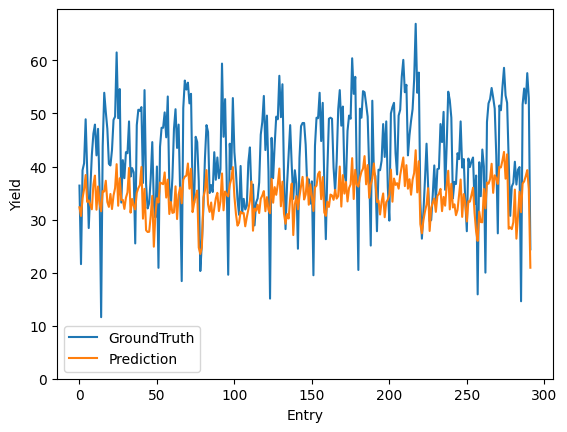

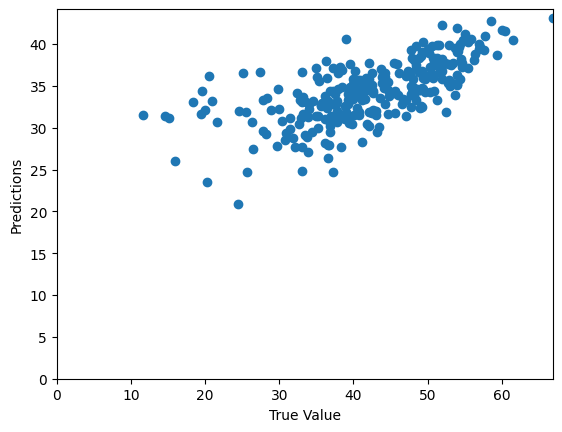

____________________________________________________
State  indiana :
MSE :  95.59000273130164
MSE Root:  9.777013998726893
MAE 8.616664000118481


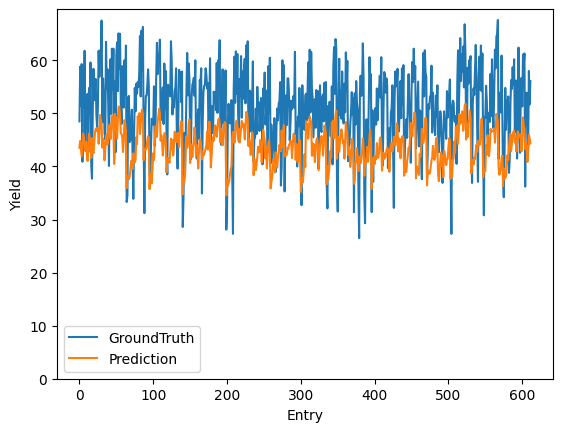

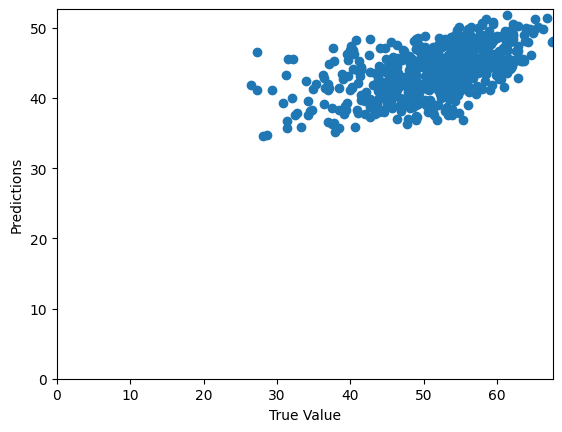

____________________________________________________
State  nebraska :
MSE :  131.41497344978134
MSE Root:  11.463637007938683
MAE 10.428350774618872


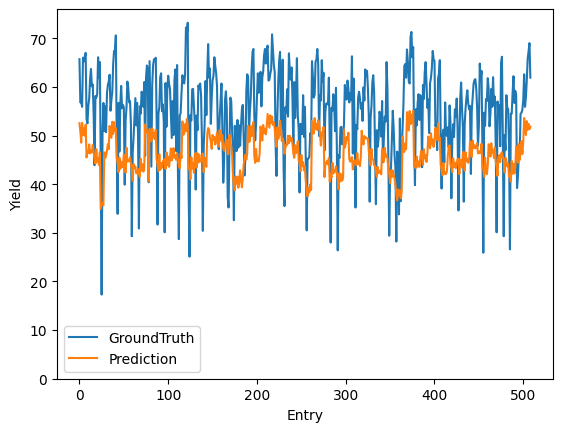

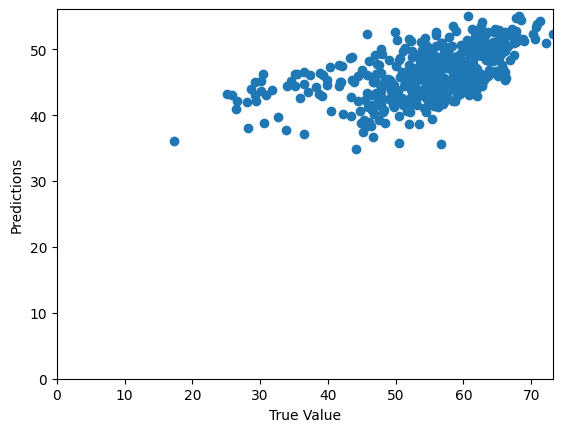

____________________________________________________
State  north dakota :
MSE :  65.36441836639443
MSE Root:  8.084826427722145
MAE 6.872700575248681


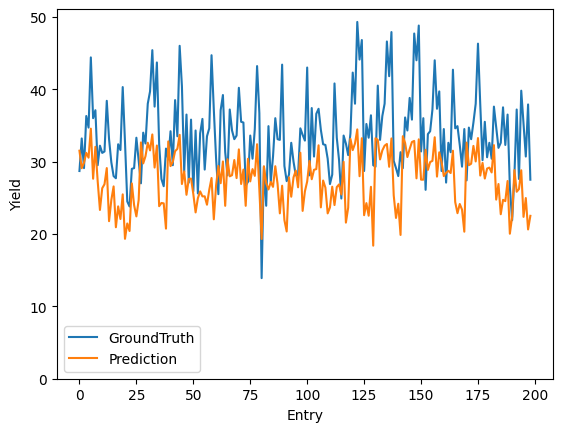

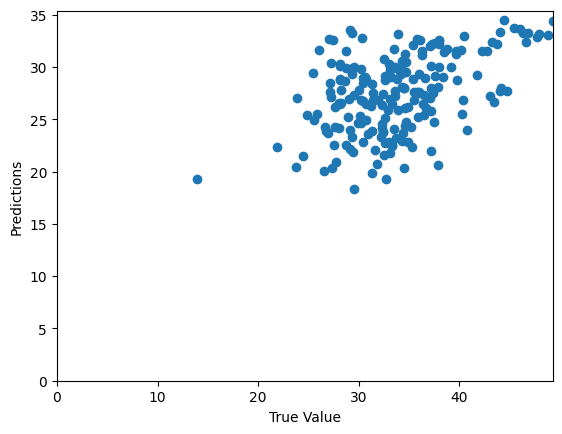

____________________________________________________
State  iowa :
MSE :  64.1417022237633
MSE Root:  8.008851492178096
MAE 6.80976724016961


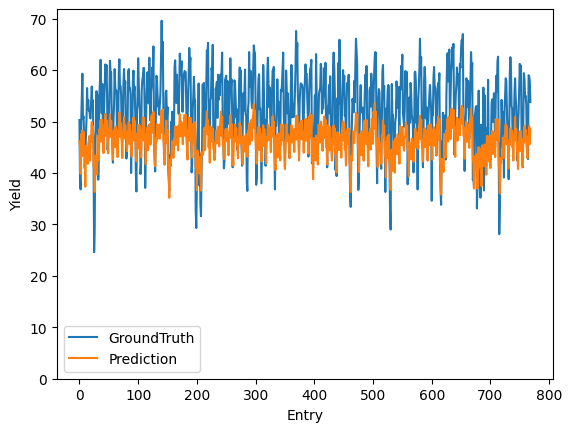

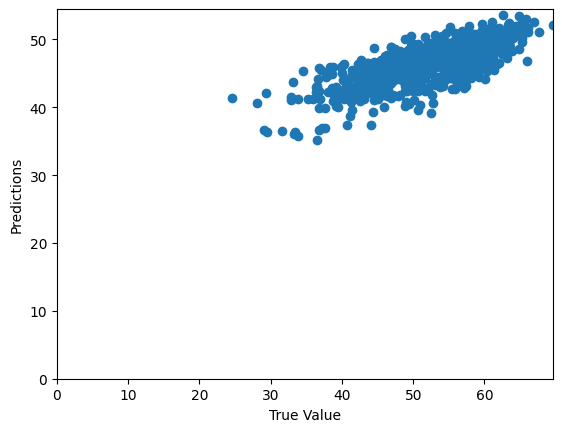

____________________________________________________
State  kansas :
MSE :  113.82570916900995
MSE Root:  10.668913214053715
MAE 9.009416355422191


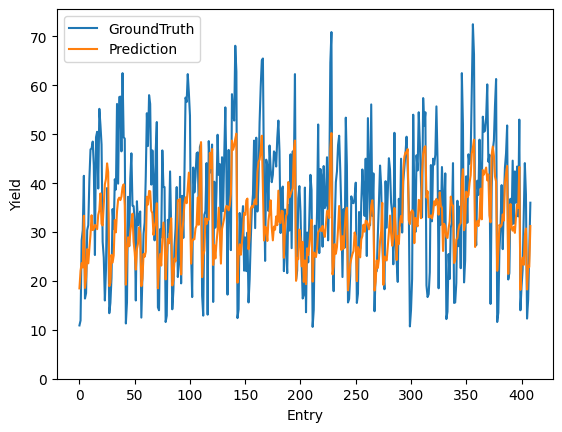

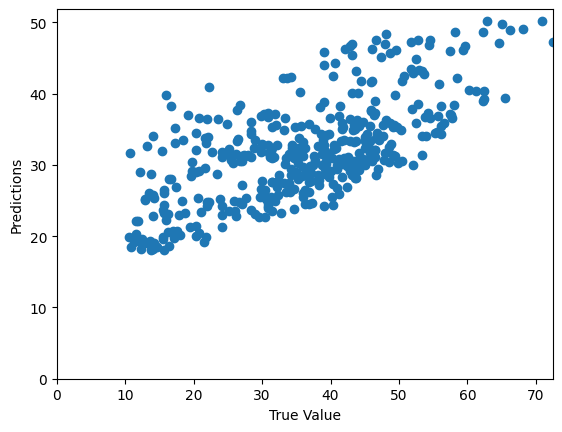

In [160]:
for state in states:
    print("____________________________________________________")
    print("State ", state, ":")
    
    mse_3_2, rmse_3_2, mae_3_2, y_pred_3_2, y_test_3_2 = pred_state(state, xgb)

#### Experiment 3: Non-outlier dataset forecasting

MSE :  82.86024759508813
MSE Root:  9.10276043819061
MAE 7.842396493819269


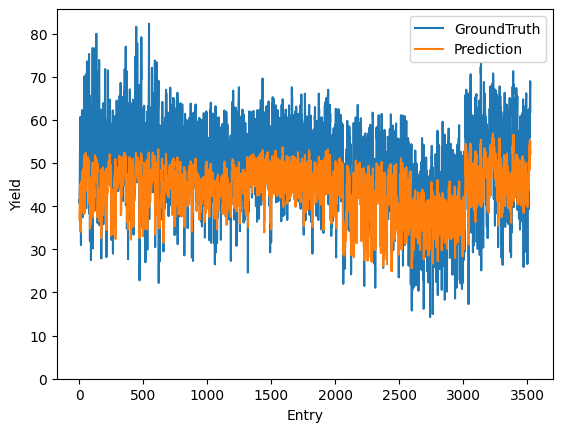

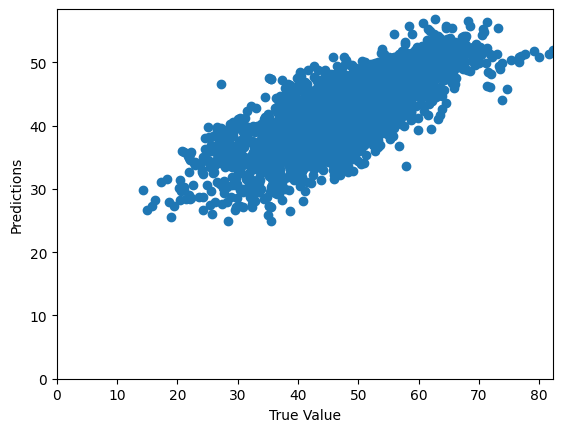

In [142]:
xgb_fitted_state_6, mse_3_3, rmse_3_3, mae_3_3, y_pred_3_3, y_test_3_3 = run_model(xgb, X_train_6, y_train_6, X_test_6, y_test_6)

#### Experiment 4: Predicting outlier yield with non-outlier-train models

MSE :  82.20629921527721
MSE Root:  9.06676895124593
MAE 7.3458795338959755


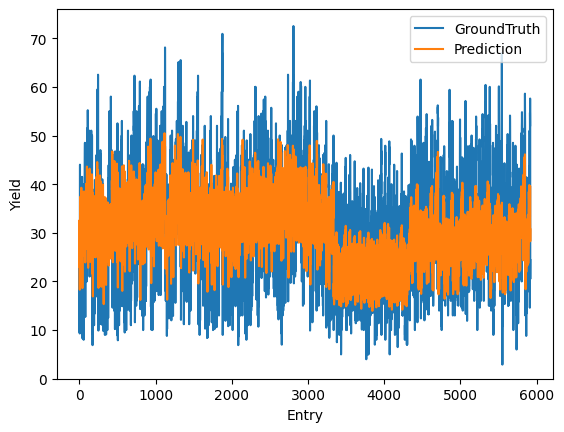

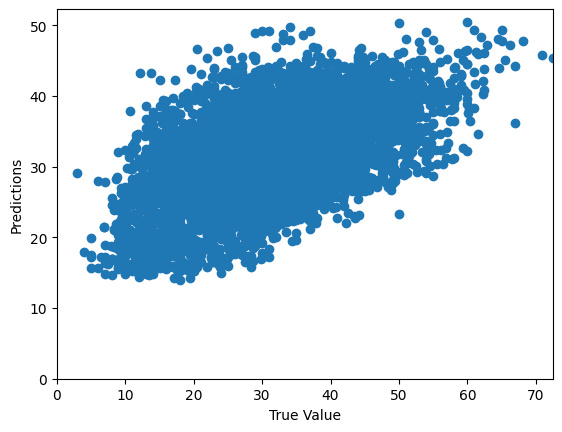

In [143]:
_, mse_3_4, rmse_3_4, mae_3_4, y_pred_4_1, y_test_4_1 = run_model(xgb_fitted_state_6, X_te = X_test_state_3, y_te = y_test_state_3, fit = False)

#### Experiment 5: Sorted data forecasting

MSE :  87.47253513163756
MSE Root:  9.352675292751137
MAE 7.99067546981491


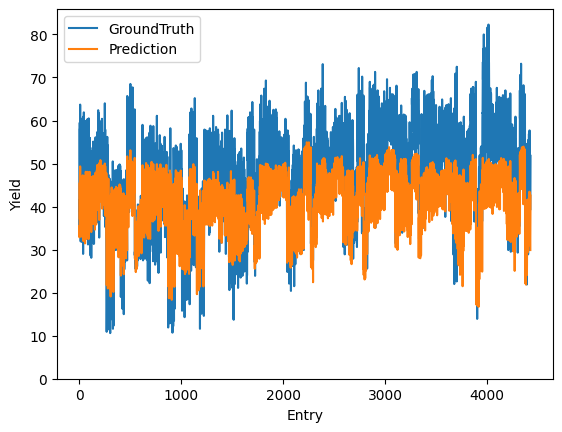

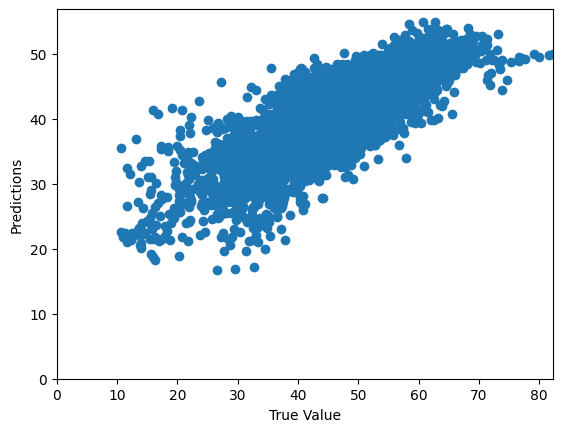

In [174]:
xgb_fitted_s, mse_3_5, rmse_3_5, mae_3_5, y_pred_3_5, y_test_3_5 = run_model(xgb,X_train_s, y_train_s, X_test_s, y_test_s)

### LSTM 

In [42]:
# Define LSTM model function
def build_lstm_model(n_epochs, batch_size, x_tr = X_train_lstm, y_tr = y_train_lstm, x_val = X_val_lstm, y_val = y_val_lstm):

    # Create neural network and configure it
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(1, x_tr.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.0005, decay=1e-6), loss='mean_squared_error')

    # Saves the model
    history = model.fit(x_tr, y_tr, epochs=n_epochs, batch_size=batch_size, verbose=0, validation_data=(x_val, y_val))

    return model, history

#### Experiment 1: Full dataset forecasting

##### Tuning

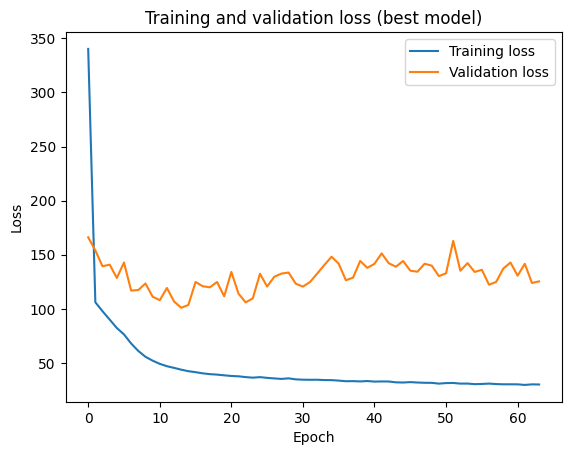

In [43]:
# Train and evaluate models with different number of epochs
n_epochs_list = [64, 128, 256, 512]
best_loss = np.inf
best_model = None
for n_epochs in n_epochs_list:
    model, history = build_lstm_model(n_epochs, 100)
    score = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
    if score < best_loss:
        best_loss = score
        best_model = model
        best_history = history

# Plot training and validation loss over epochs for best model
plt.plot(best_history.history['loss'], label='Training loss')
plt.plot(best_history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss (best model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


##### Prediction

In [79]:
lstm, history = build_lstm_model(64, 100)

139/139 [==============================] - 0s 2ms/step
MSE :  77.36475575908102
MSE Root:  8.795723720029013
MAE 6.8474129185871515


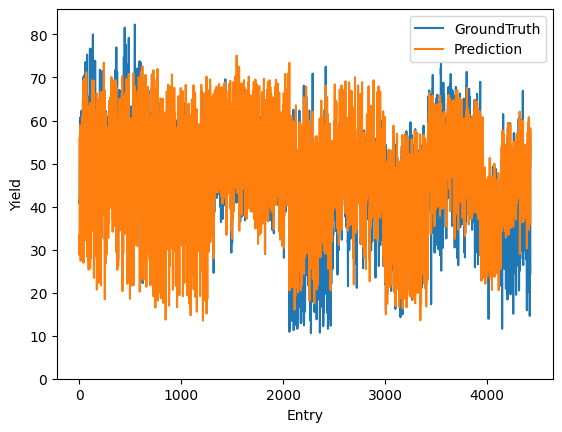

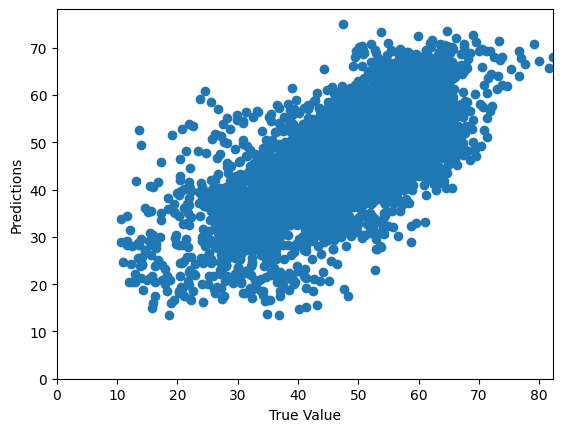

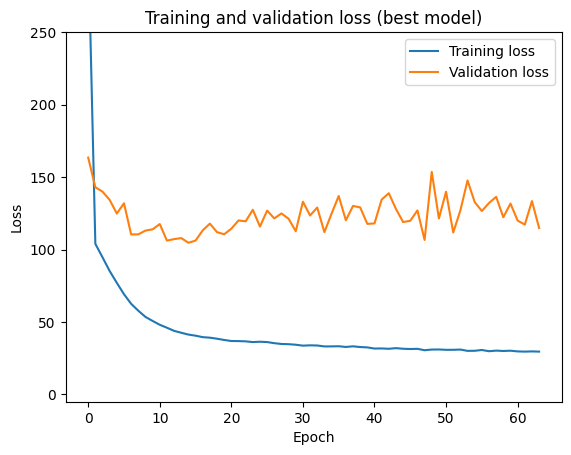

In [151]:
_, mse_4_1, rmse_4_1, mae_4_1, y_pred_4_1, y_test_4_1 = run_model(lstm, X_te = X_test_lstm, y_te = y_test_lstm, fit = False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss (best model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(-5, 250)
plt.legend()
plt.show()


#### Experiment 2: Per-state forecasting

____________________________________________________
State  illinois :
22/22 [==============================] - 0s 2ms/step
MSE :  147.16529613581312
MSE Root:  12.131170435527363
MAE 10.015445929134593


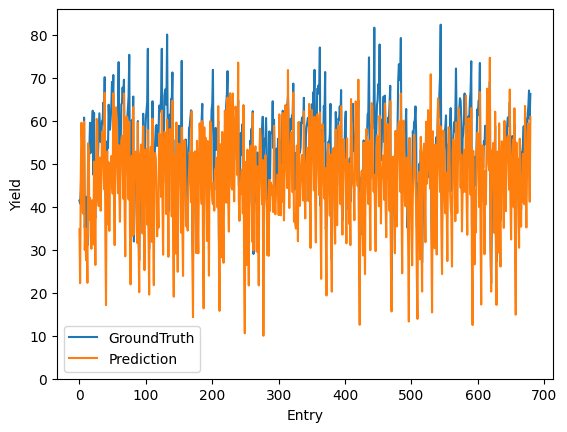

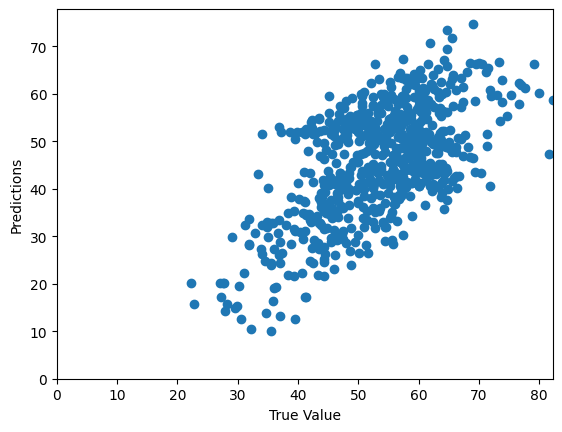

____________________________________________________
State  missouri :
14/14 [==============================] - 0s 2ms/step
MSE :  70.32473657154154
MSE Root:  8.385984532035671
MAE 6.64903213801009


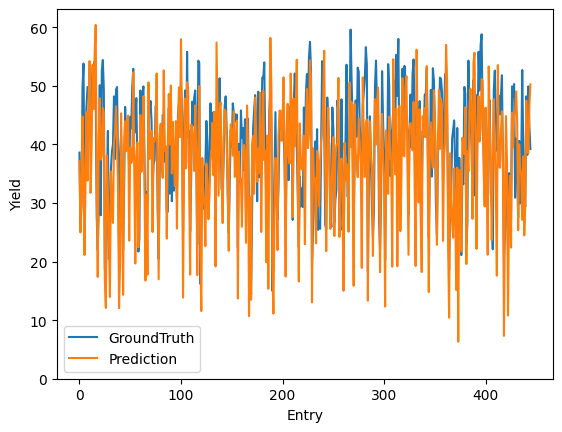

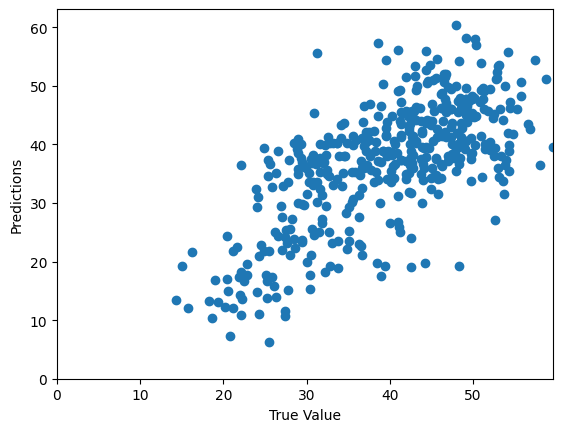

____________________________________________________
State  minnesota :
16/16 [==============================] - 0s 2ms/step
MSE :  147.69013626676286
MSE Root:  12.152783066720268
MAE 9.294979152455927


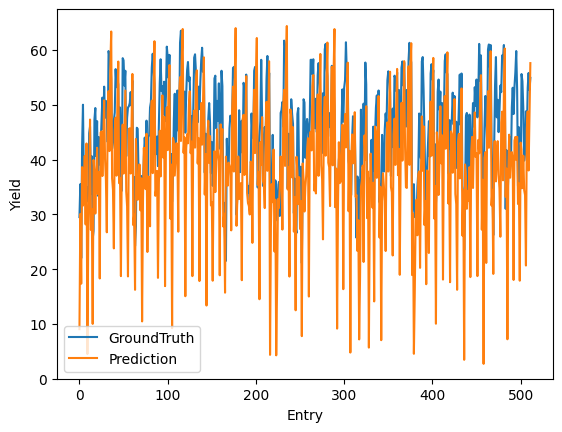

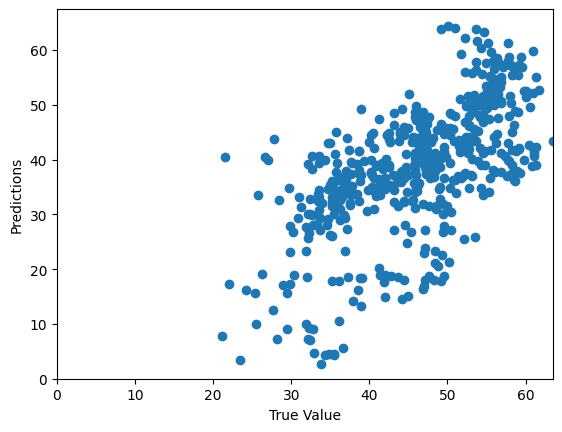

____________________________________________________
State  south dakota :
10/10 [==============================] - 0s 2ms/step
MSE :  68.11419028656711
MSE Root:  8.253132150072911
MAE 6.846060239452206


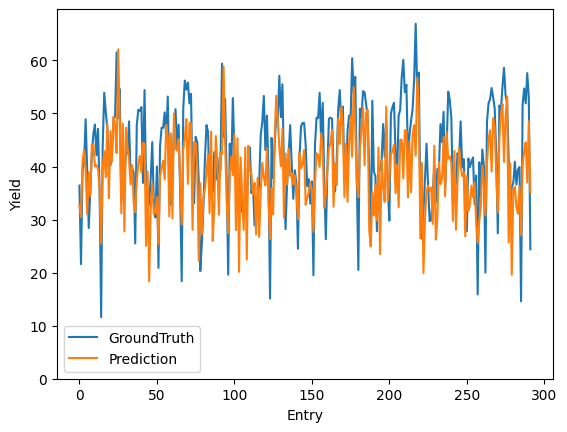

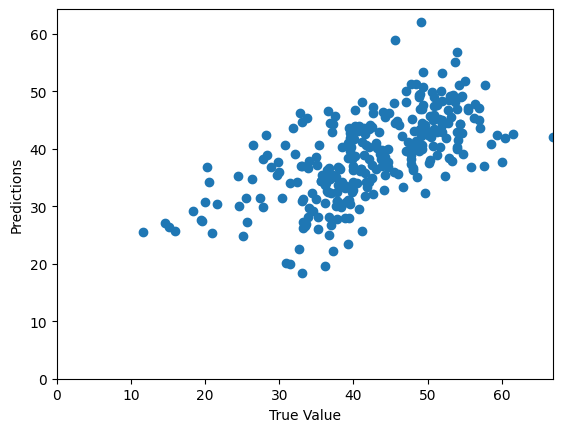

____________________________________________________
State  indiana :
20/20 [==============================] - 0s 2ms/step
MSE :  153.05483375077367
MSE Root:  12.37153320129618
MAE 9.441377572140663


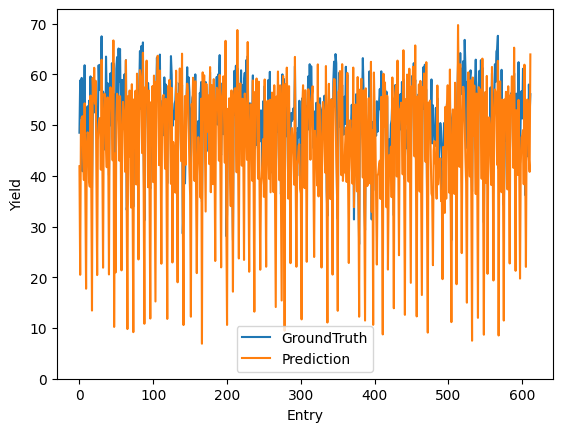

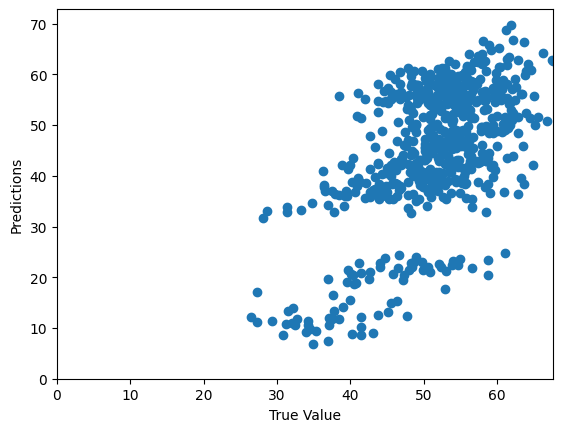

____________________________________________________
State  nebraska :
16/16 [==============================] - 0s 3ms/step
MSE :  118.88512362209589
MSE Root:  10.90344549315013
MAE 8.60914020126133


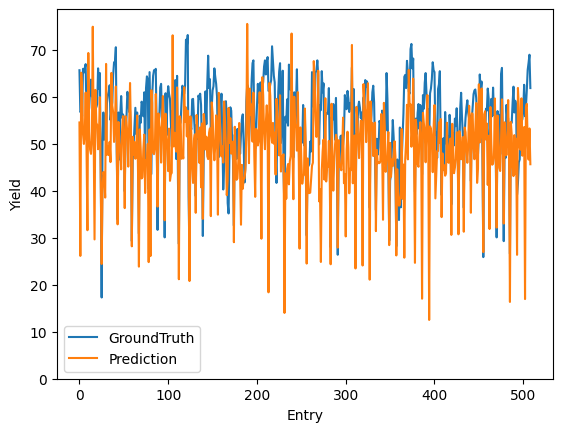

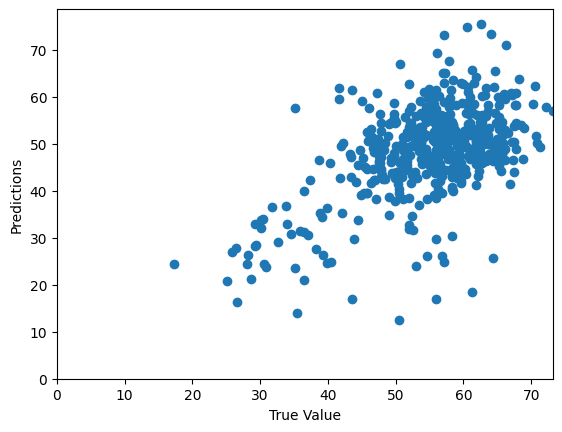

____________________________________________________
State  north dakota :
7/7 [==============================] - 0s 2ms/step
MSE :  79.70369566796359
MSE Root:  8.927692628443454
MAE 7.536997086798126


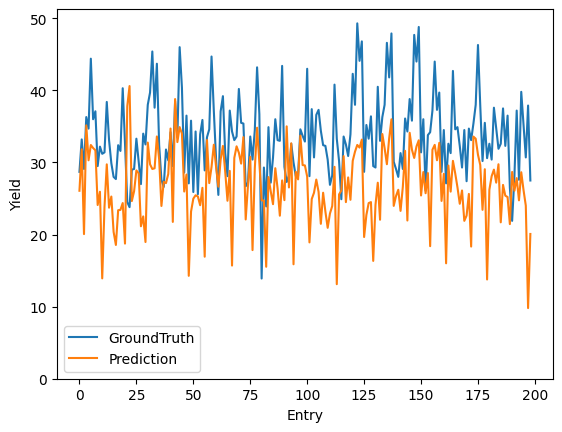

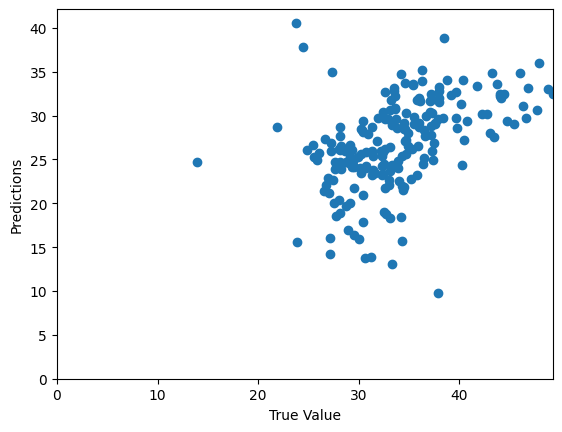

____________________________________________________
State  iowa :
25/25 [==============================] - 0s 2ms/step
MSE :  84.30136148663976
MSE Root:  9.18157728751655
MAE 7.15017511494293


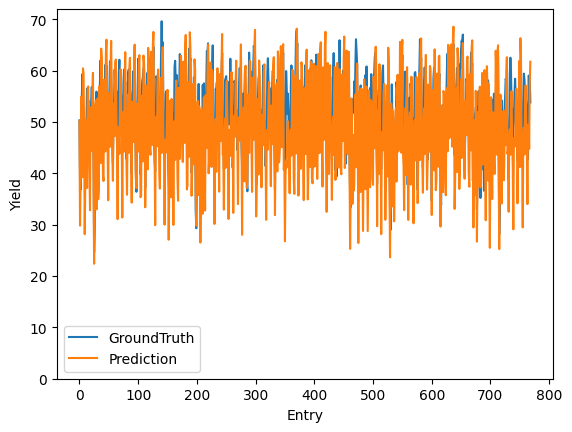

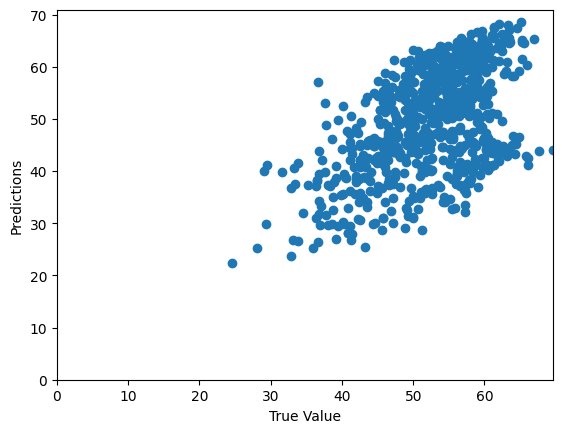

____________________________________________________
State  kansas :
13/13 [==============================] - 0s 2ms/step
MSE :  209.68275823695552
MSE Root:  14.480426728413619
MAE 10.534917075126852


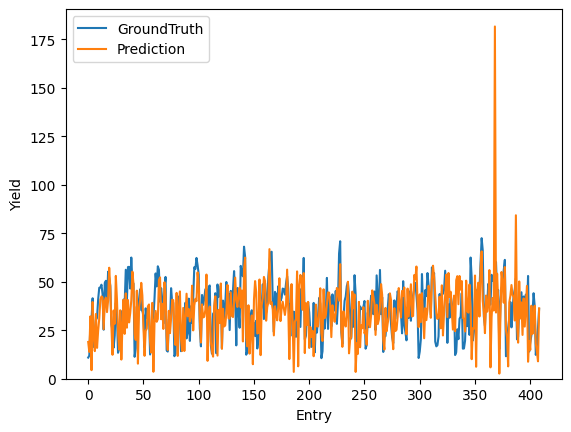

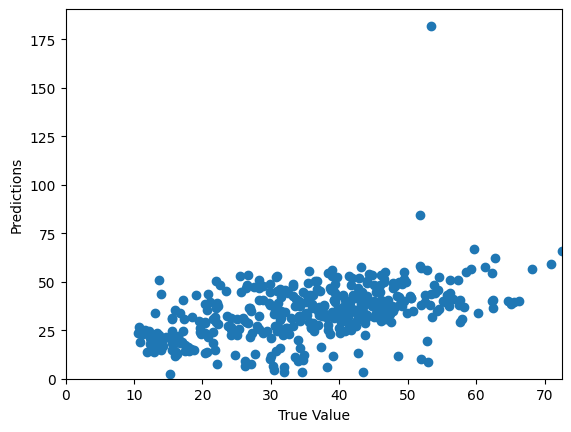

In [178]:
for state in states:
    print("____________________________________________________")
    print("State ", state, ":")
    mse_4_2, rmse_4_2, mae_4_2, y_pred_4_2, y_test_4_2 = pred_state(state, lstm, val_set = True)

#### Experiment 3: Non-outlier dataset forecasting

111/111 [==============================] - 0s 2ms/step
MSE :  71.22449100999602
MSE Root:  8.439460350638305
MAE 6.5688346828723505


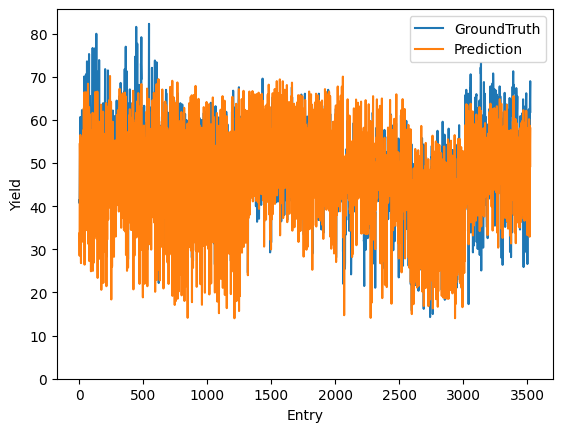

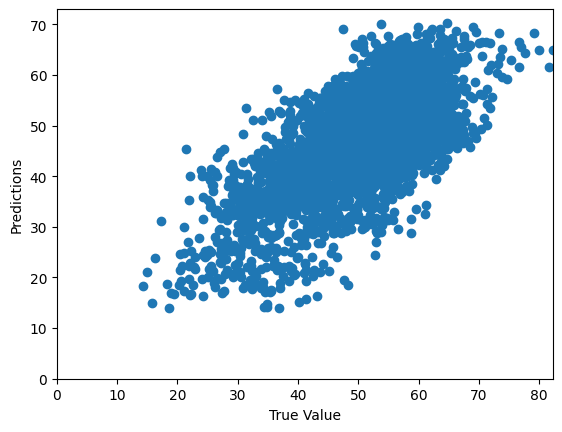

In [157]:
print("____________________________________________________")
print("State ", state, ":")

lstm_state_6, mse_4_3, rmse_4_3, mae_4_3, y_pred_4_3, y_test_4_3 = run_model(lstm, X_train_lstm_6, y_train_lstm_6, X_test_lstm_6, y_test_lstm_6, X_val_lstm_6, y_val_lstm_6)

#### Experiment 4: Predicting outlier yield with non-outlier-train models

185/185 [==============================] - 0s 2ms/step
MSE :  20244.098615426043
MSE Root:  142.28175784486936
MAE 43.79929608914368


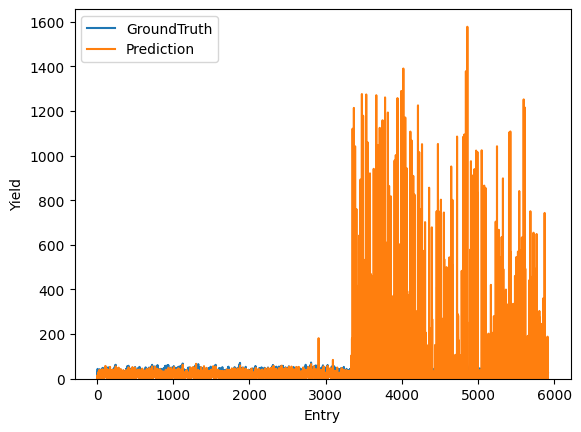

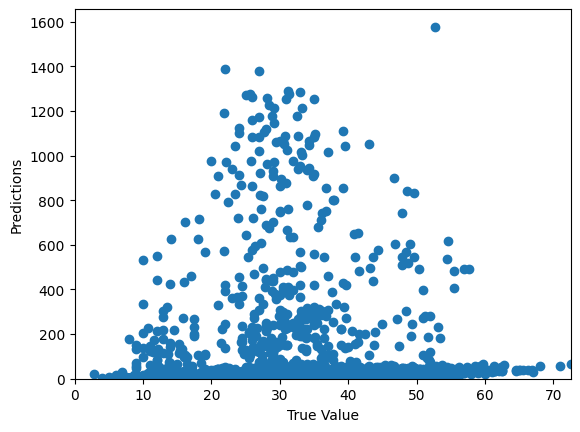

In [179]:
_, mse_4_4, rmse_4_4, mae_4_4, y_pred_4_4, y_test_4_4 = run_model(lstm_state_6, X_te = X_test_lstm_state_3, y_te = y_test_state_3, fit = False)

#### Experiment 5: Sorted data forecasting

139/139 [==============================] - 0s 2ms/step
MSE :  76.62487446555963
MSE Root:  8.753563529532395
MAE 6.723962113850268


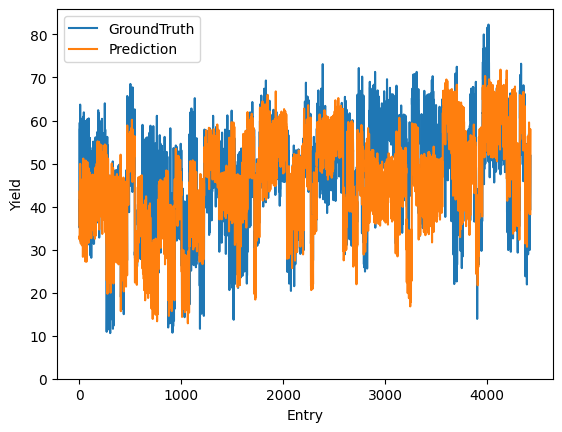

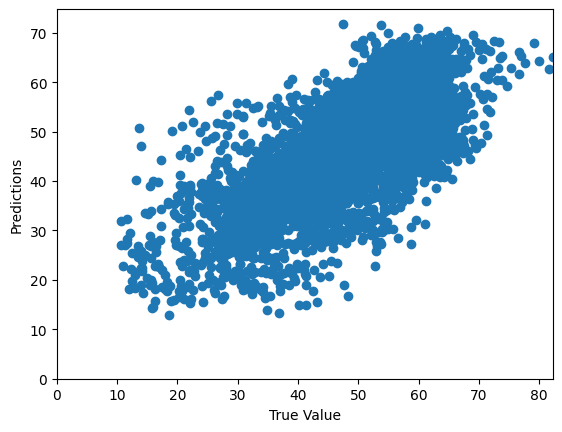

In [176]:
lstm_s, mse_4_5, rmse_4_5, mae_4_5, y_pred_4_5, y_test_4_5 = run_model(lstm, X_train_lstm_s, y_train_lstm_s, X_test_lstm_s, y_test_lstm_s, X_val_lstm_s, y_val_lstm_s)

## Transformer

### Auxilary methods for transformers

In [26]:
import torch
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, lookback, horizon):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.X) - self.lookback - self.horizon + 1

    def __getitem__(self, index):
        index += self.lookback
        x = self.X[index - self.lookback:index]
        y = self.y[index + self.horizon - 1]
        return x, y


def generate_dataset(X, y, lookback, horizon):
    dataset = TimeSeriesDataset(X, y, lookback, horizon)
    return dataset
